In [260]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
from collections import Counter
import cpi
import ast
import json
import datetime
from sklearn.decomposition import PCA
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from sklearn import preprocessing
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import math

In [66]:
# Common functions

# Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

def plot_itemset(title, result, dataset_size, rotation=90):
    plt.figure(figsize=(20,12))
    sns.barplot([", ".join(list(x)) for x in result["itemsets"]], [x * dataset_size for x in result["support"]])
    plt.xticks(fontsize=12,rotation=rotation)
    plt.title(title,fontsize=20)
    plt.show()

In [3]:
# Datasets loading
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset = dataset_original

oscars = pd.read_csv('./tmdb-box-office-prediction/the_oscar_award.csv')
oscars_winners = oscars[oscars["winner"] == True].drop(columns=["winner", "year_film", "year_ceremony", "ceremony", "category", "name"])
oscars_winners = oscars_winners[oscars_winners["film"].notnull()]
dataset_lc = dataset.copy()
oscars_winners_lc = oscars_winners.copy()
dataset_lc['title'] = dataset_lc['title'].str.lower()
oscars_winners_lc['film'] = oscars_winners_lc['film'].str.lower()
oscar_movies = pd.merge(left=dataset_lc, right=oscars_winners_lc, left_on='title', right_on='film').drop_duplicates(subset='id')
oscar_movies = oscar_movies.drop(columns=['film'])

dataset = text_to_dict(dataset)
oscar_movies = text_to_dict(oscar_movies)

In [4]:
oscar_movies.info()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 516
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     227 non-null    int64  
 1   belongs_to_collection  227 non-null    object 
 2   budget                 227 non-null    int64  
 3   genres                 227 non-null    object 
 4   homepage               73 non-null     object 
 5   imdb_id                227 non-null    object 
 6   original_language      227 non-null    object 
 7   original_title         227 non-null    object 
 8   overview               227 non-null    object 
 9   popularity             227 non-null    float64
 10  poster_path            227 non-null    object 
 11  production_companies   227 non-null    object 
 12  production_countries   227 non-null    object 
 13  release_date           227 non-null    object 
 14  runtime                227 non-null    float64
 15  spoken

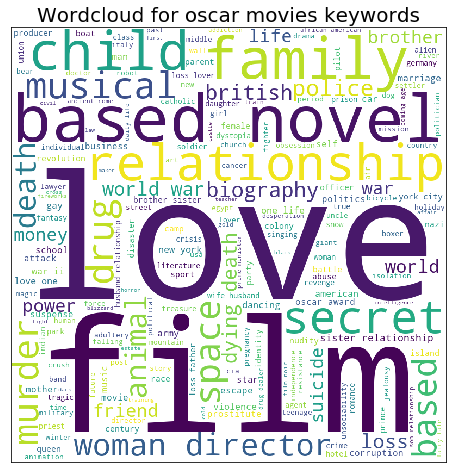

In [5]:
# Keyword words cloud analysis
def createWordCloudForWordsString(wordsString):
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(wordsString) 
    return wordcloud

keywordsMovieDataset = oscar_movies[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset.explode('Keywords').reset_index(drop=True)
keywordsList = keywordsMovieDataset['Keywords'].values.tolist()

oscarMoviesKeywords = ' '

for word in keywordsList: 
    oscarMoviesKeywords = oscarMoviesKeywords + str(word) + ' '

# Plot oscar movies keywords wordcloud                
plt.figure(figsize = (8, 8)) 
plt.imshow(createWordCloudForWordsString(oscarMoviesKeywords)) 
plt.title("Wordcloud for oscar movies keywords",fontsize=20)  
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show() 

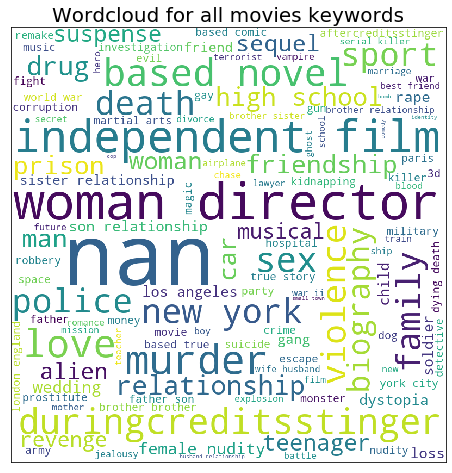

In [6]:
keywordsMovieDataset = dataset[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset.explode('Keywords').reset_index(drop=True)
keywordsList = keywordsMovieDataset['Keywords'].values.tolist()

allMoviesKeywords = ' '

for word in keywordsList: 
    allMoviesKeywords = allMoviesKeywords + str(word) + ' '

# Plot all movies keywords wordcloud                
plt.figure(figsize = (8, 8)) 
plt.imshow(createWordCloudForWordsString(allMoviesKeywords)) 
plt.title("Wordcloud for all movies keywords",fontsize=20)  
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show() 

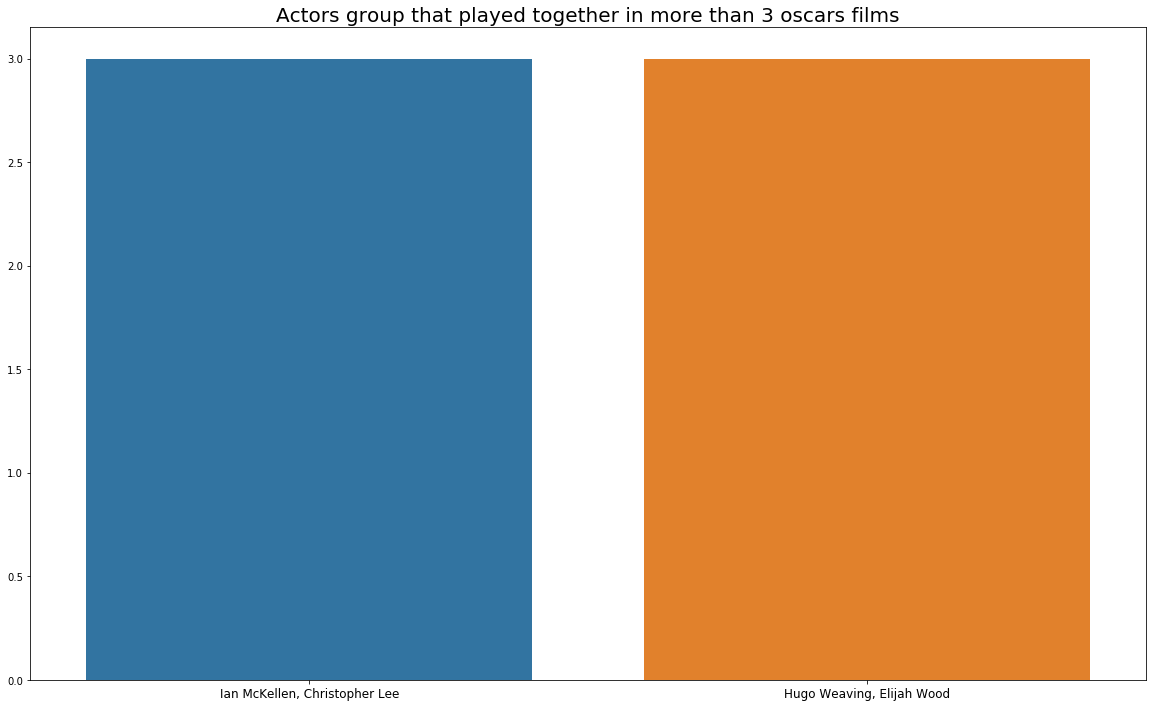

In [5]:
def calculate_support(min_occurence_number, dataset_size):
    return min_occurence_number / dataset_size

# Actors most frequent itemsets for oscar movies
actorMovieDataset = oscar_movies[['id','title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset['cast']

te = TransactionEncoder()
te_ary = te.fit(actorMovieDataset).transform(actorMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=calculate_support(3,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets.sort_values('length', ascending=True)
plot_itemset("Actors group that played together in more than 3 oscars films", frequent_itemsets, len(df), rotation=0)

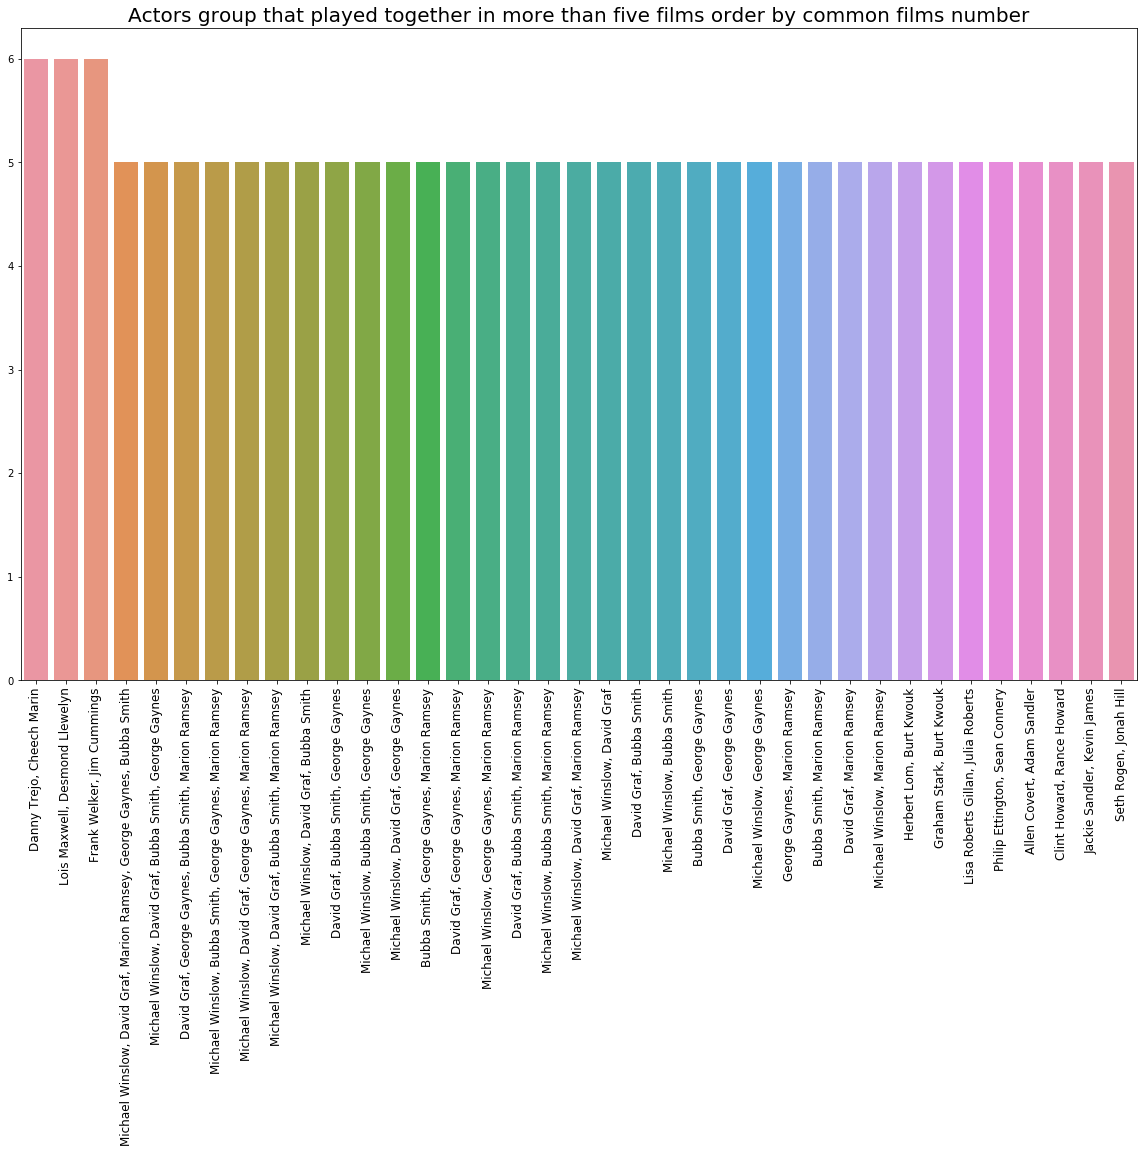

In [40]:
# Actors clustering for all movies
actorMovieDataset = dataset[['id','title','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
actorMovieDataset = actorMovieDataset['cast']

te = TransactionEncoder()
te_ary = te.fit(actorMovieDataset).transform(actorMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df, min_support=calculate_support(5,len(df)), max_len=5,use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Actors group that played together in more than 5 films order by common films number", frequent_itemsets, len(df), rotation=90)

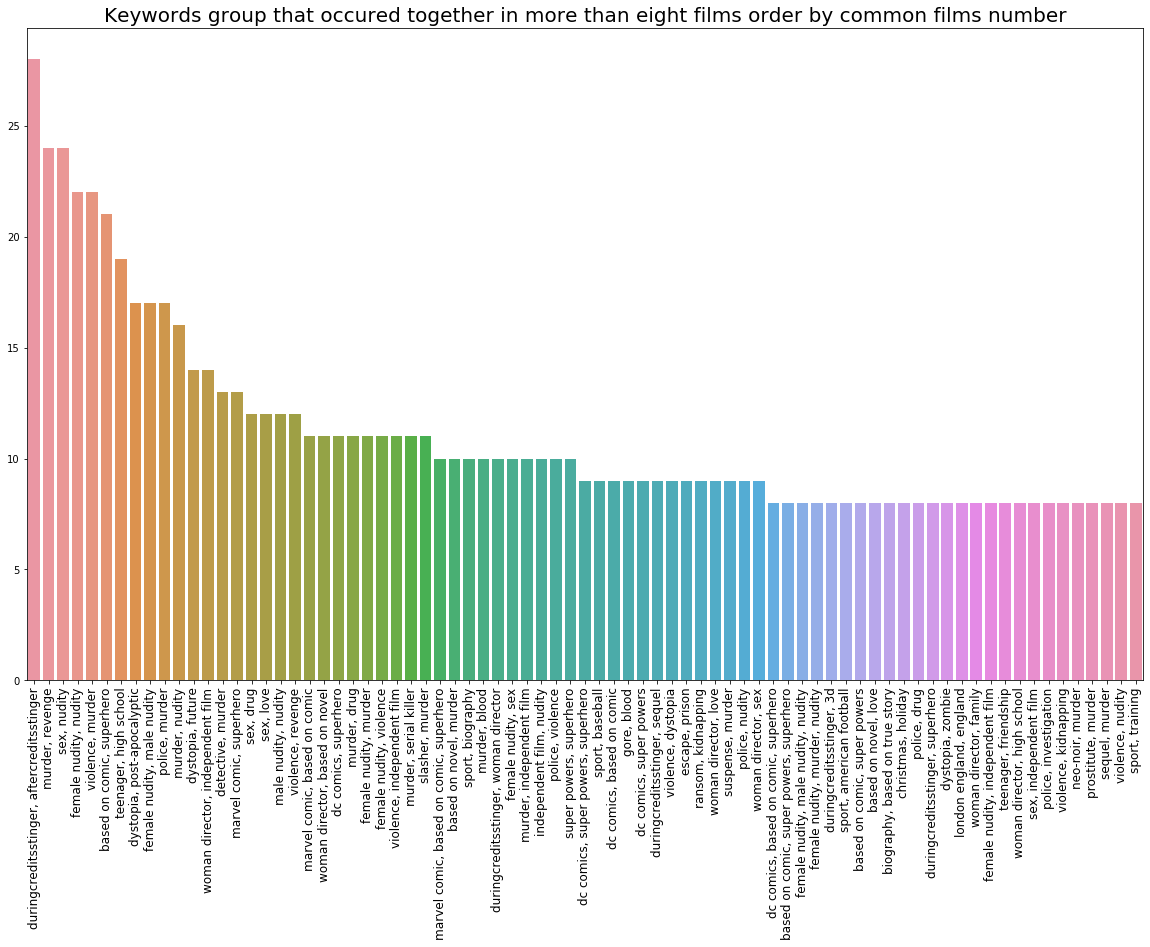

In [33]:
# Keywords clustering for all movies
keywordsMovieDataset = dataset[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset['Keywords']

te = TransactionEncoder()
te_ary = te.fit(keywordsMovieDataset).transform(keywordsMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(8,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Keywords group that occured together in more than 8 films order by common films number", frequent_itemsets, len(df), rotation=90)

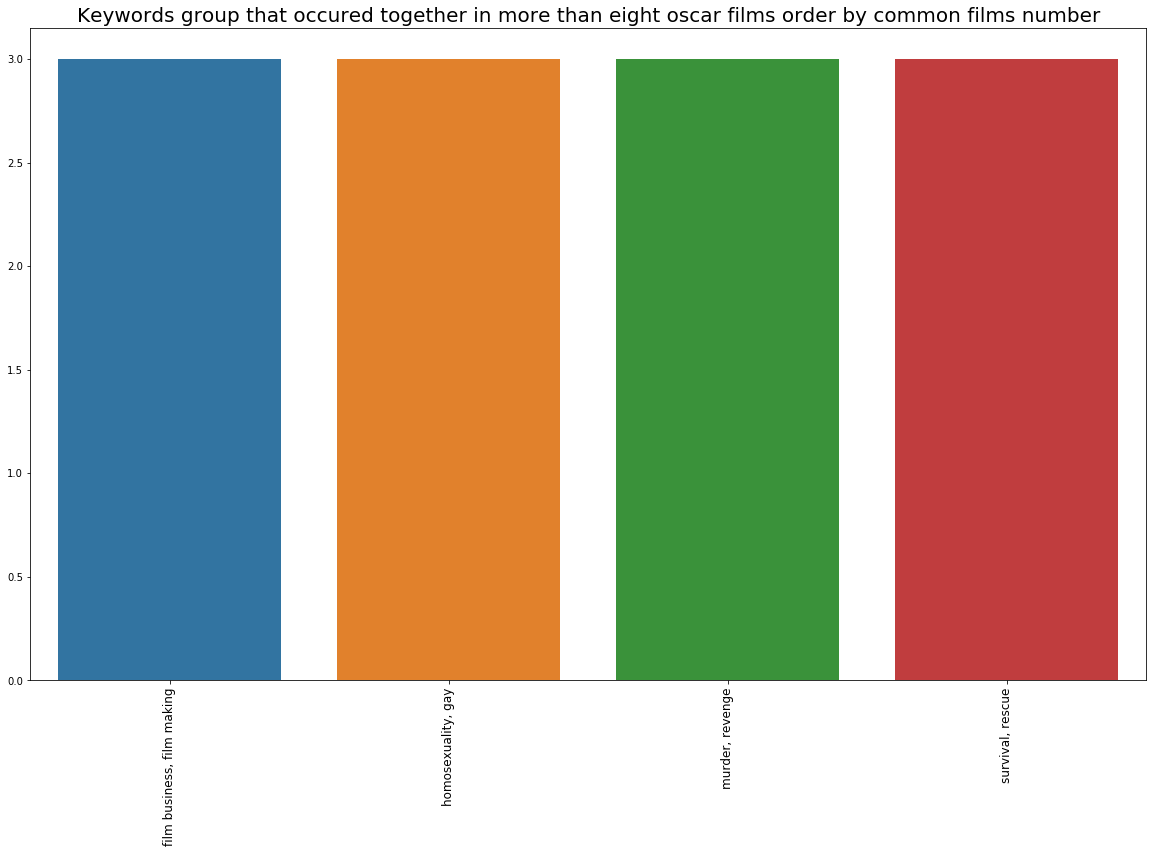

In [38]:
# Keywords clustering for oscar movies
keywordsMovieDataset = oscar_movies[['id','title','Keywords']].copy()
keywordsMovieDataset['Keywords'] = keywordsMovieDataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
keywordsMovieDataset = keywordsMovieDataset['Keywords']

te = TransactionEncoder()
te_ary = te.fit(keywordsMovieDataset).transform(keywordsMovieDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(3,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Keywords group that occured together in more than 3 oscar films order by common films number", frequent_itemsets, len(df), rotation=90)

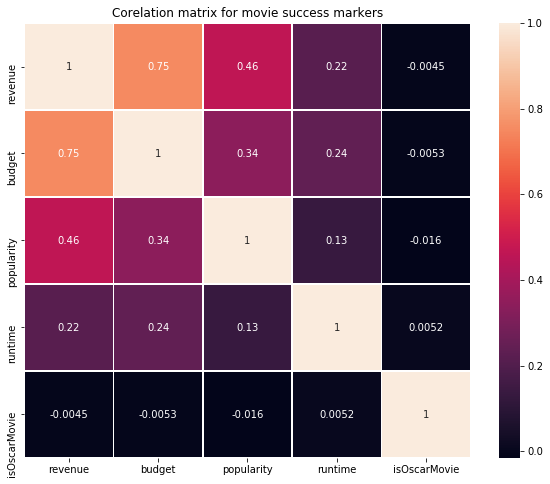

In [39]:
# Making corelation matrix
dataset['isOscarMovie'] = dataset['id'].apply(lambda x: 1 if x in oscar_movies['id'] else 0)
col = ['revenue','budget','popularity','runtime','isOscarMovie']
plt.subplots(figsize=(10, 8))
plt.title('Correlation matrix for movie success markers')
corr = dataset[col].corr()
sns.heatmap(corr, annot=True, xticklabels=col,yticklabels=col, linewidths=.5)

In [11]:
# Multidimensional most frequent itemsets
features_vector = ['Keywords', 'cast', 'crew','production_companies','budget', 'revenue']
dataset[features_vector]

,Keywords,cast,crew,budget,revenue
0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",14000000,12314651
1,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",40000000,95149435
2,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",3300000,13092000
3,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",1200000,16000000
4,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",0,3923970
...,...,...,...,...,...
2995,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",0,1596687
2996,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",0,180590
2997,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",65000000,89456761
2998,"[{'id': 966, 'name': 'beach'}, {'id': 2676, 'n...","[{'cast_id': 8, 'character': 'Reuben Feffer', ...","[{'credit_id': '556f817b9251410866000a63', 'de...",42000000,171963386


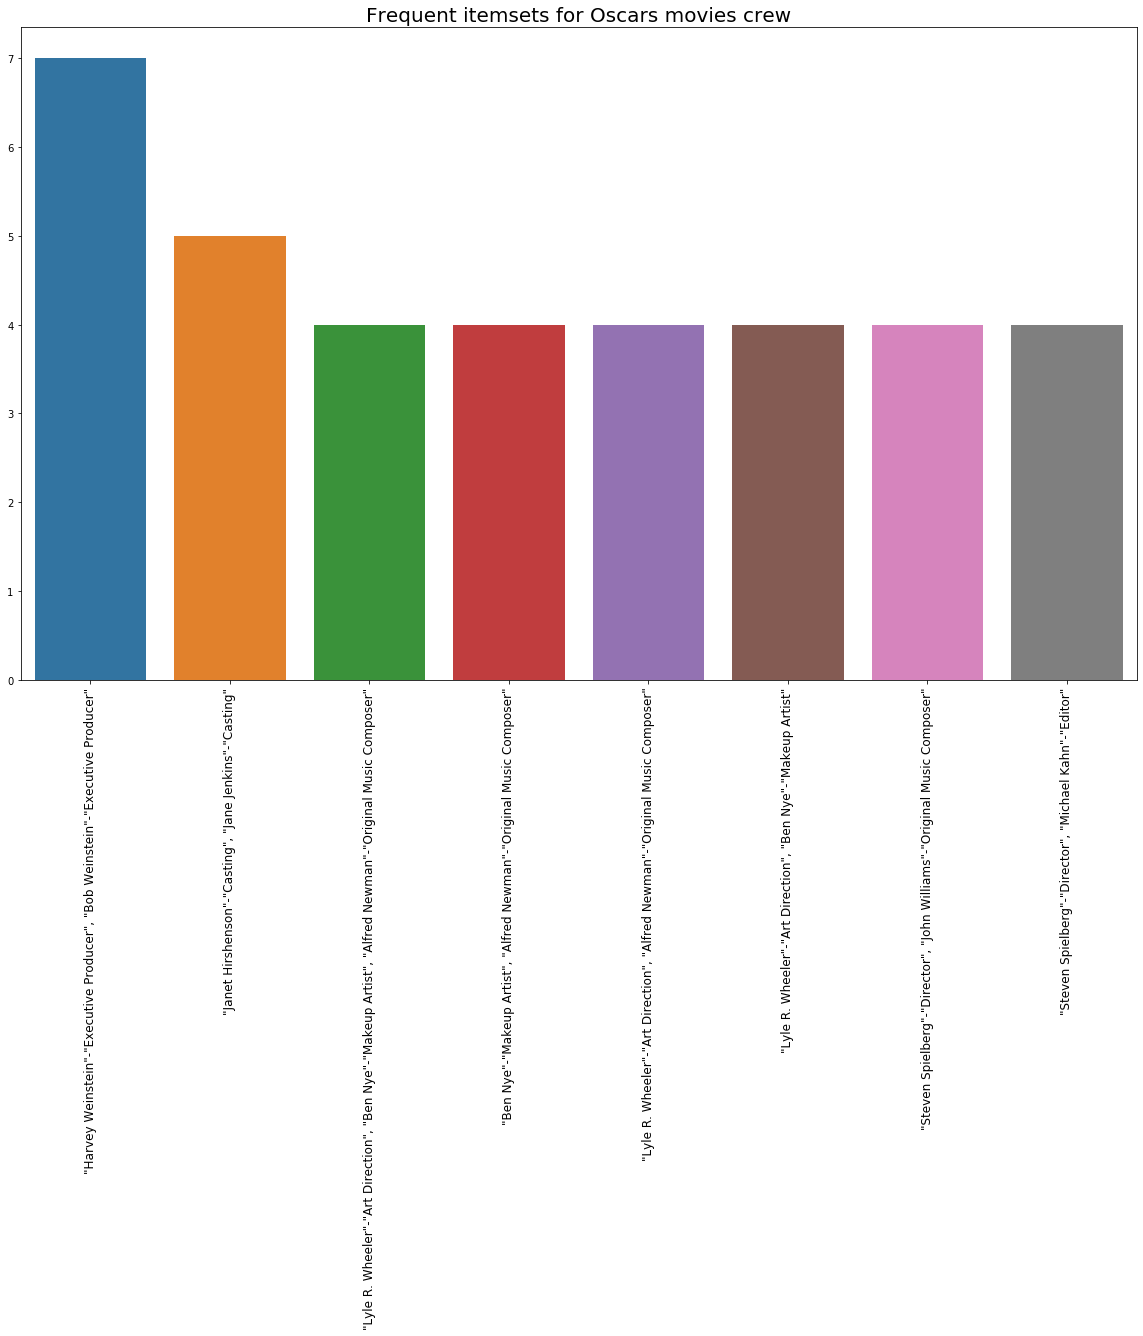

In [17]:
# Film crem most frequent itemsets in oscar films
crewDataset = oscar_movies[['id','title','crew']].copy()
crewDataset['crew'] = crewDataset['crew'].apply(lambda x: ['\"'+i['name']+'\"-\"'+i['job']+'\"' for i in x] if x != {} else [])
crewDataset = crewDataset['crew']

te = TransactionEncoder()
te_ary = te.fit(crewDataset).transform(crewDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(4,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for Oscars movies crew", frequent_itemsets, len(df), rotation=90)

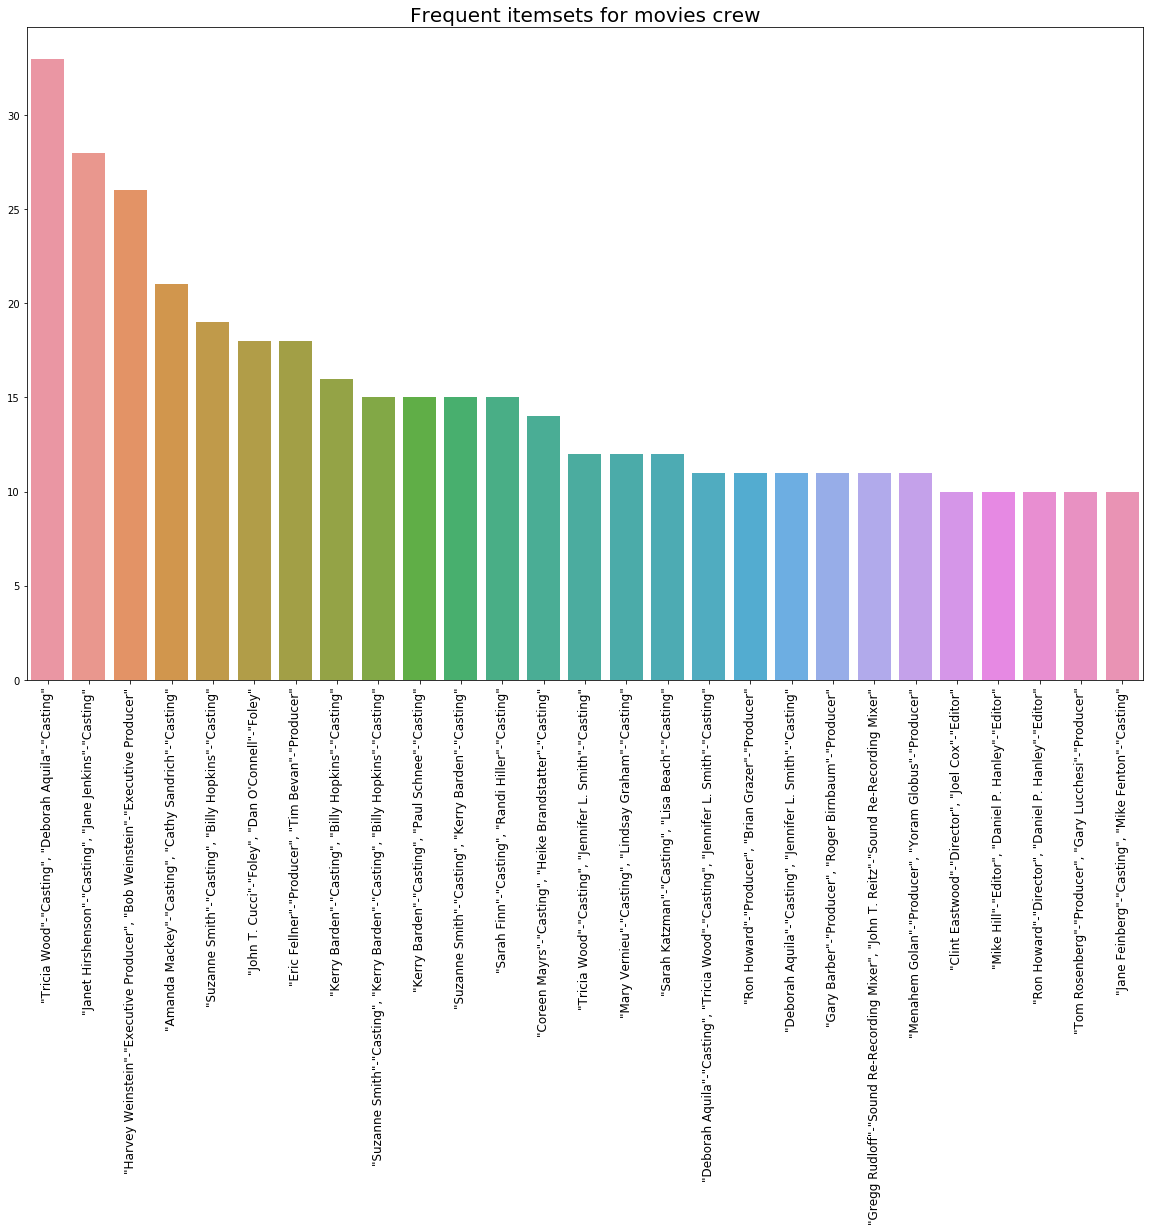

In [72]:
# Film crem most frequent itemsets in films
crewDataset = dataset[['id','title','crew']].copy()
crewDataset['crew'] = crewDataset['crew'].apply(lambda x: ['\"'+i['name']+'\"-\"'+i['job']+'\"' for i in x] if x != {} else [])
crewDataset = crewDataset['crew']

te = TransactionEncoder()
te_ary = te.fit(crewDataset).transform(crewDataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(10,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies crew", frequent_itemsets, len(df), rotation=90)

In [21]:
def classify_movie_budget(budget):
    if budget == 0:
        return 'no data'
    elif budget < 400000:
        return 'micro-budget'
    elif budget < 2000000:
        return 'low-budget'
    elif budget < 10000000:
        return 'middle-budget'
    else:
        return 'high-budget'

In [101]:
processedDataset = oscar_movies.copy()
features_vector = ['Keywords', 'cast', 'production_companies']
processedDataset = processedDataset[features_vector]

processedDataset['Keywords'] = processedDataset['Keywords'].apply(lambda x: [i['name']+'-Keyword' for i in x] if x != {} else [])
processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
#processedDataset['crew'] = processedDataset['crew'].apply(lambda x: [i['name']+'-'+i['job'] for i in x] if x != {} else [])
#processedDataset['budget'] = processedDataset['budget'].apply(lambda x: [classify_movie_budget(x)])
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [item for items in x for item in items])
processedDataset

,Keywords,cast,production_companies,budget,elements
0,"[jazz-Keyword, obsession-Keyword, conservatory...","[Miles Teller-Cast, J.K. Simmons-Cast, Melissa...","[Bold Films-Company, Blumhouse Productions-Com...",[middle-budget],"[jazz-Keyword, obsession-Keyword, conservatory..."
3,"[underdog-Keyword, philadelphia-Keyword, trans...","[Sylvester Stallone-Cast, Talia Shire-Cast, Bu...",[United Artists-Company],[low-budget],"[underdog-Keyword, philadelphia-Keyword, trans..."
6,"[male nudity-Keyword, female nudity-Keyword, a...","[Kevin Spacey-Cast, Annette Bening-Cast, Thora...","[DreamWorks SKG-Company, Jinks/Cohen Company-C...",[high-budget],"[male nudity-Keyword, female nudity-Keyword, a..."
11,"[prison-Keyword, rebel-Keyword, loss of mother...","[Paul Newman-Cast, George Kennedy-Cast, Luke A...","[Warner Bros.-Company, Jalem Productions-Company]",[middle-budget],"[prison-Keyword, rebel-Keyword, loss of mother..."
12,"[bounty hunter-Keyword, wyoming-Keyword, mount...","[Samuel L. Jackson-Cast, Kurt Russell-Cast, Je...","[Double Feature Films-Company, The Weinstein C...",[high-budget],"[bounty hunter-Keyword, wyoming-Keyword, mount..."
...,...,...,...,...,...
506,"[from rags to riches-Keyword, tutor-Keyword, s...","[Albert Finney-Cast, Susannah York-Cast, Hugh ...",[Woodfall Film Productions-Company],[low-budget],"[from rags to riches-Keyword, tutor-Keyword, s..."
510,"[france-Keyword, robbery-Keyword, brothel-Keyw...",[],"[Universal Pictures-Company, Relativity Media-...",[high-budget],"[france-Keyword, robbery-Keyword, brothel-Keyw..."
513,"[suicide-Keyword, gambling-Keyword, manager-Ke...","[Paul Newman-Cast, Jackie Gleason-Cast, Piper ...",[Twentieth Century Fox Film Corporation-Compan...,[middle-budget],"[suicide-Keyword, gambling-Keyword, manager-Ke..."
515,"[servant-Keyword, money-Keyword, shooting part...","[Helen Mirren-Cast, Clive Owen-Cast, Maggie Sm...",[USA Films-Company],[high-budget],"[servant-Keyword, money-Keyword, shooting part..."


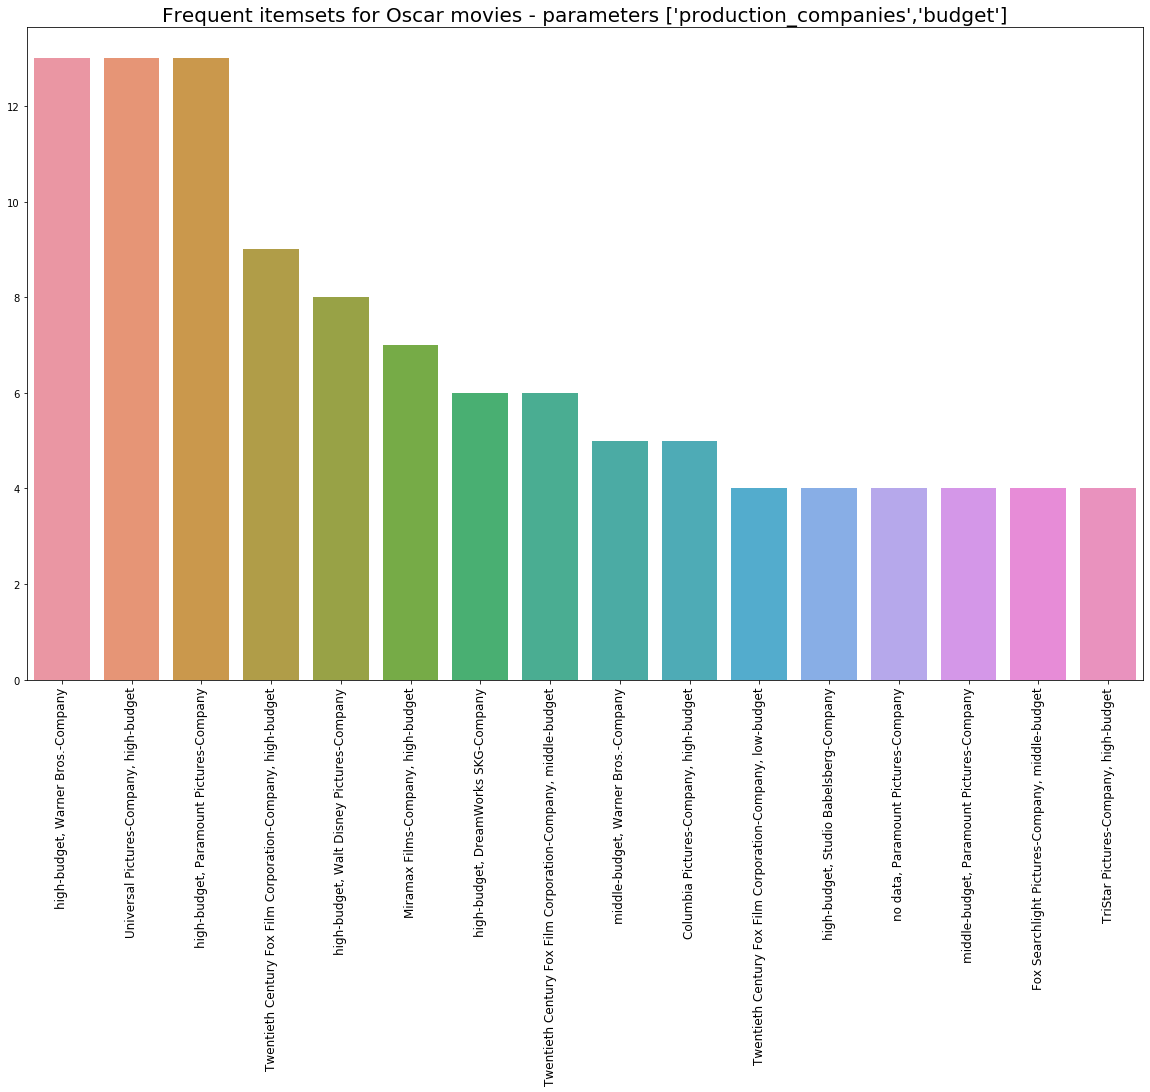

In [111]:
# Making multidimensional frequent datasets for movies vector
processedDataset = oscar_movies.copy()
features_vector = ['production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: [classify_movie_budget(x)])
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [item for items in x for item in items])
processedDataset

ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(4,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for Oscar movies - parameters ['production_companies','budget']", frequent_itemsets, len(df), rotation=90)

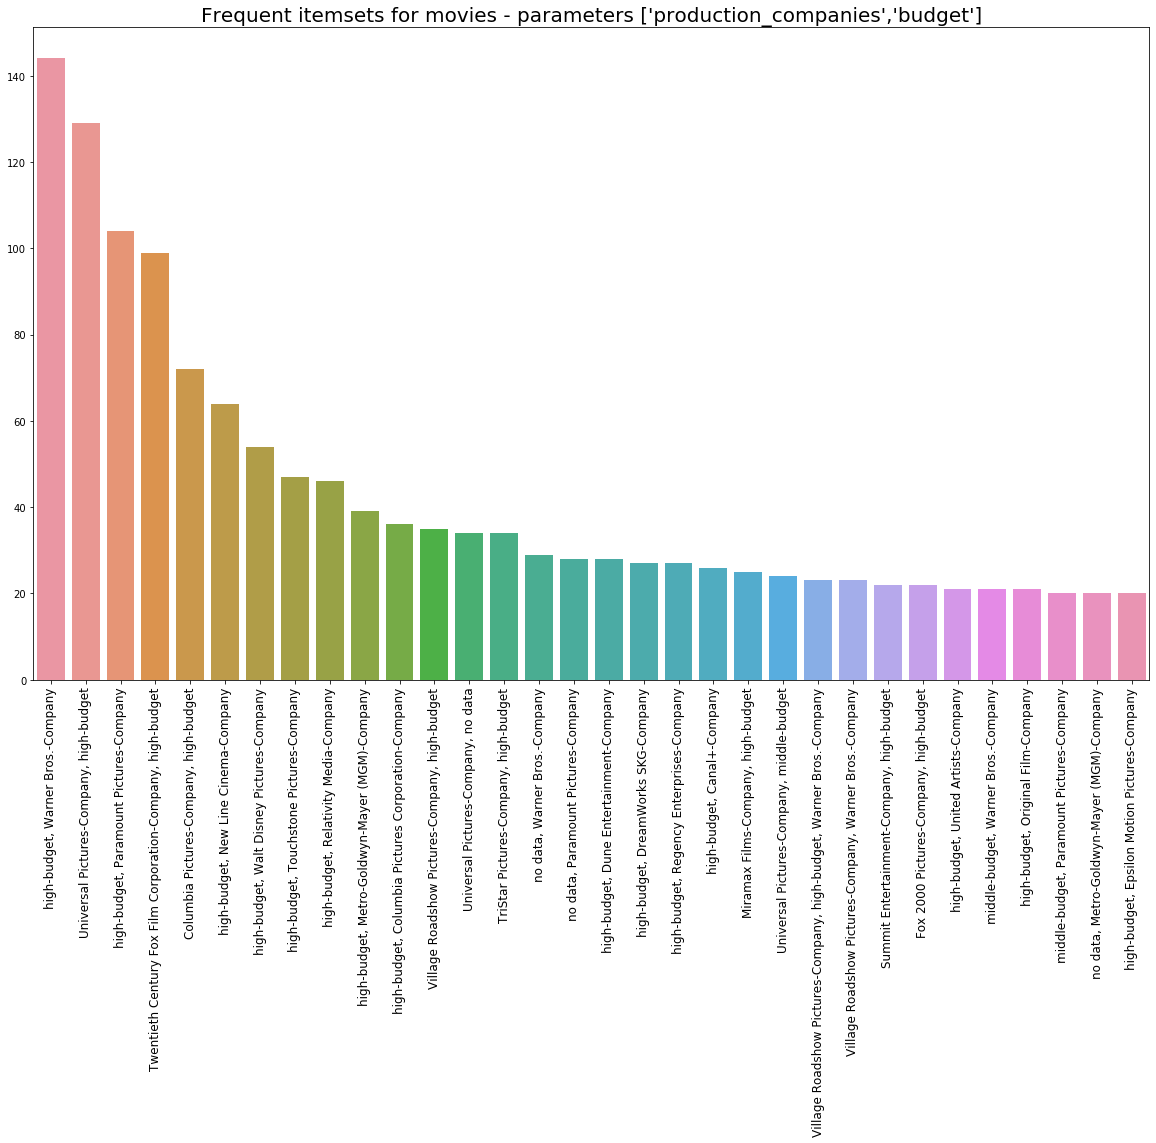

In [112]:
# Making multidimensional frequent datasets for movies vector
processedDataset = dataset.copy()
features_vector = ['production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: [classify_movie_budget(x)])
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [item for items in x for item in items])
processedDataset

ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(20,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies - parameters ['production_companies','budget']", frequent_itemsets, len(df), rotation=90)

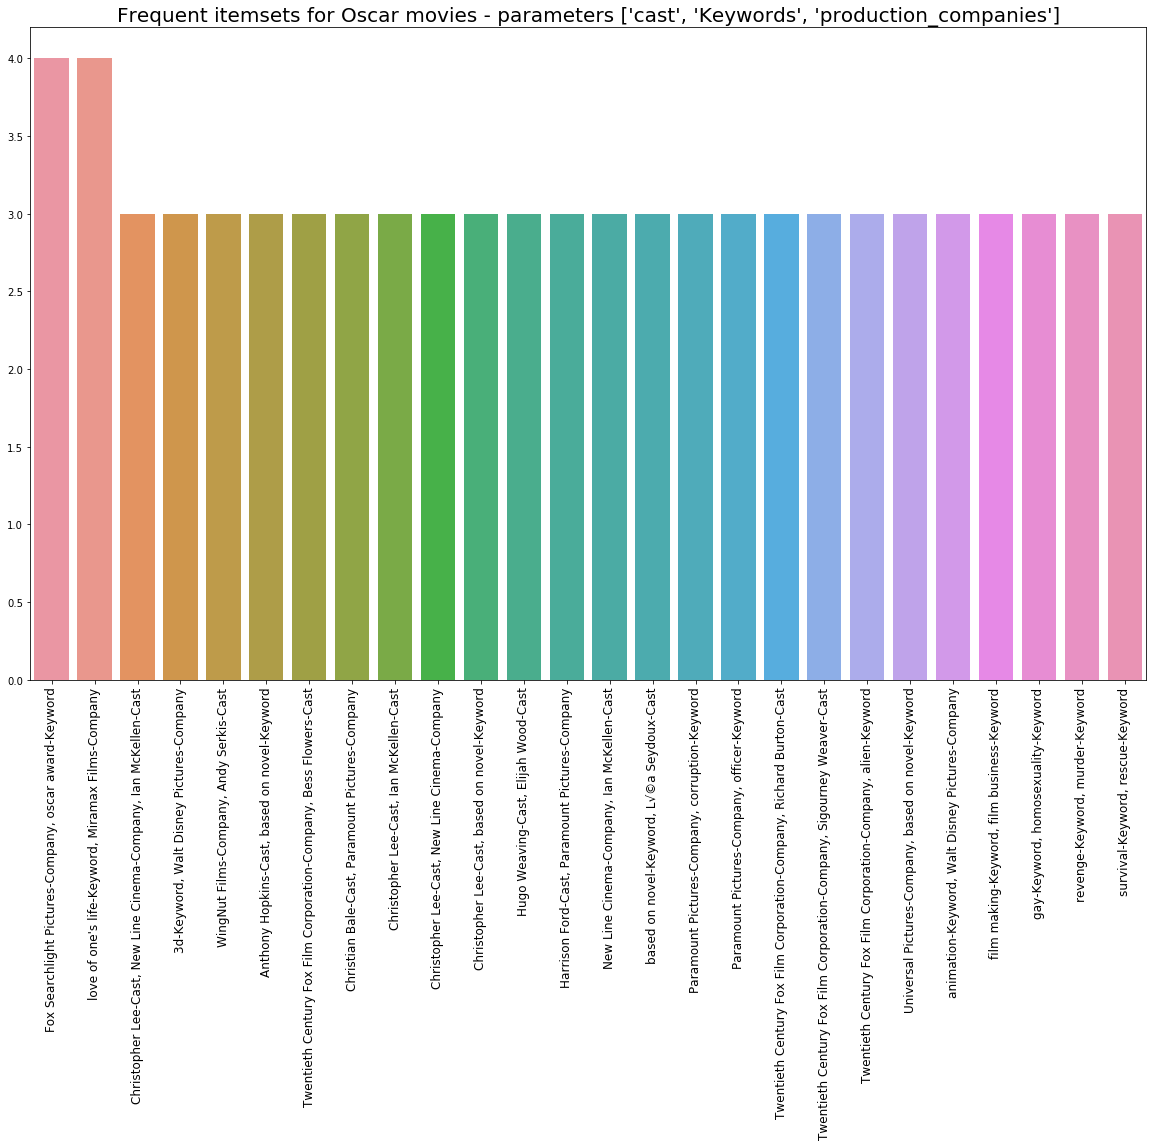

In [116]:
# Making multidimensional frequent datasets for movies vector
processedDataset = oscar_movies.copy()
features_vector = ['cast','Keywords','production_companies']
processedDataset = processedDataset[features_vector]

processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['Keywords'] = processedDataset['Keywords'].apply(lambda x: [i['name']+'-Keyword' for i in x] if x != {} else [])
processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [item for items in x for item in items])
processedDataset

ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df,min_support=calculate_support(3,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for Oscar movies - parameters ['cast', 'Keywords', 'production_companies']", frequent_itemsets, len(df), rotation=90)

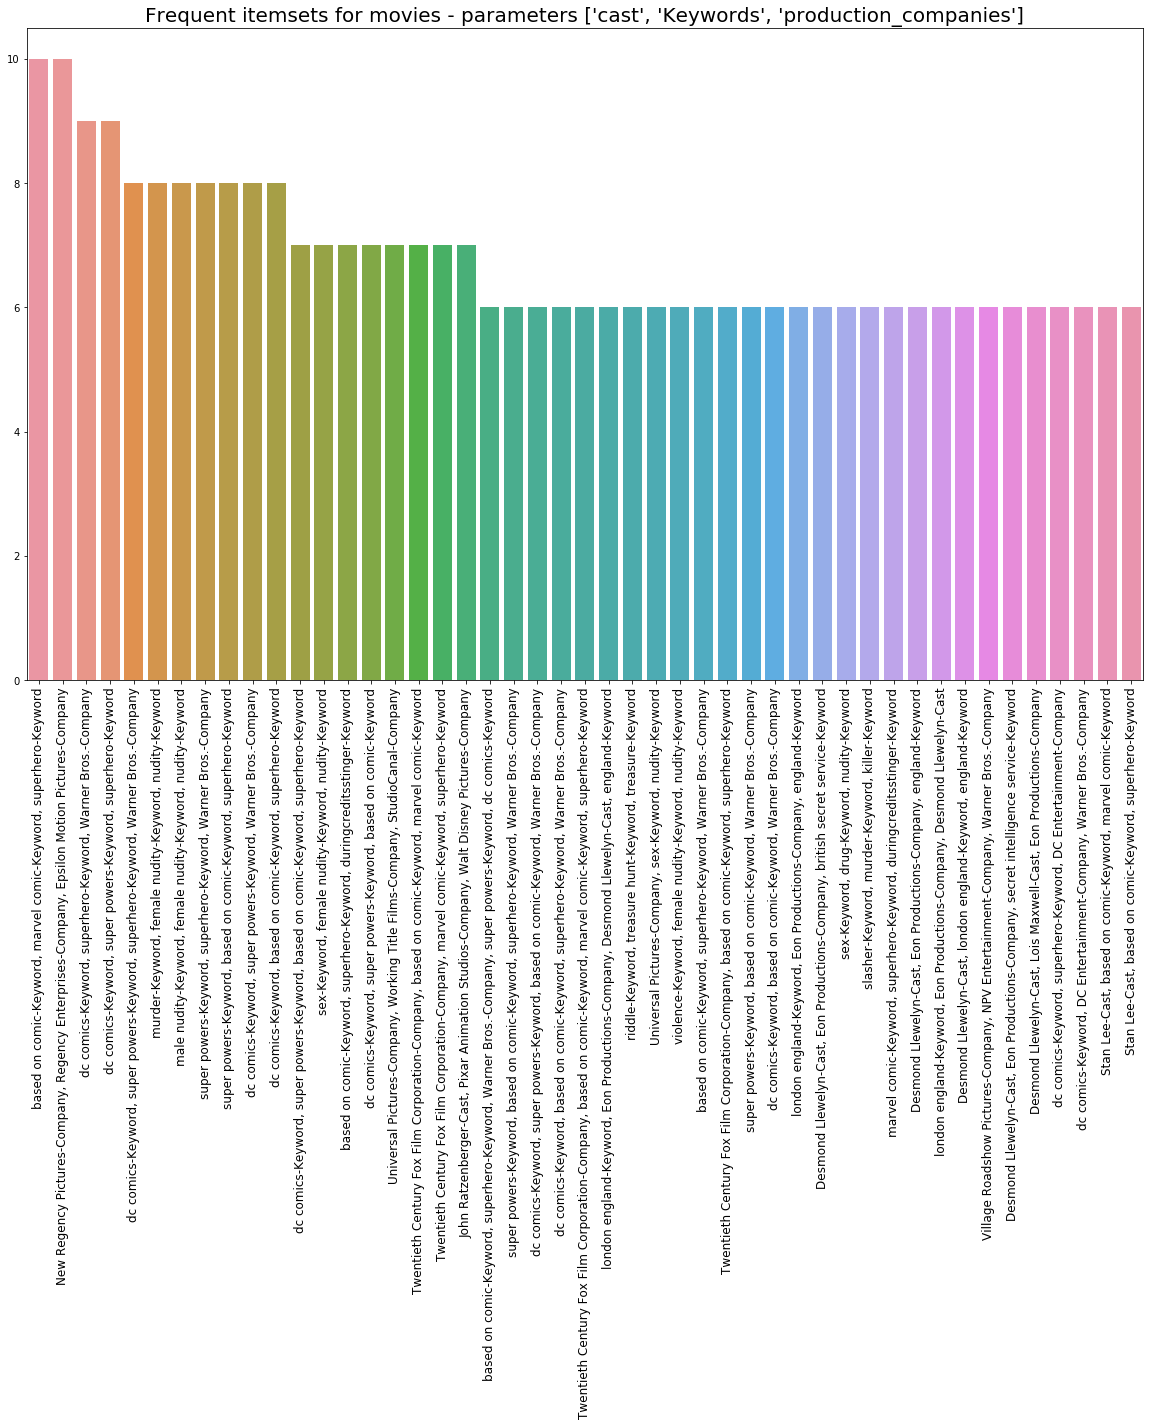

In [123]:
# Making multidimensional frequent datasets for movies vector
processedDataset = dataset.copy()
features_vector = ['cast','Keywords','production_companies']
processedDataset = processedDataset[features_vector]

processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['Keywords'] = processedDataset['Keywords'].apply(lambda x: [i['name']+'-Keyword' for i in x] if x != {} else [])
processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [item for items in x for item in items])
processedDataset

ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(6,len(df)), max_len=5, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# Uncomment to filter
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies - parameters ['cast', 'Keywords', 'production_companies']", frequent_itemsets, len(df), rotation=90)

In [138]:
#Frequet itemsets for resolved vectors
processedDataset = oscar_movies.copy()
features_vector = ['Keywords', 'production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['Keywords'] = processedDataset['Keywords'].apply(lambda x: [i['name']+'-Keyword' for i in x] if x != {} else [])
#processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
#processedDataset['crew'] = processedDataset['crew'].apply(lambda x: [i['name']+'-'+i['job'] for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: classify_movie_budget(x))
processedDataset = processedDataset.explode('Keywords').reset_index(drop=True)
#processedDataset = processedDataset.explode('cast').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
#processedDataset = processedDataset.explode('crew').reset_index(drop=True)
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset

,Keywords,production_companies,budget,elements
0,jazz-Keyword,Bold Films-Company,middle-budget,"[jazz-Keyword, Bold Films-Company, middle-budget]"
1,jazz-Keyword,Blumhouse Productions-Company,middle-budget,"[jazz-Keyword, Blumhouse Productions-Company, ..."
2,jazz-Keyword,Right of Way Films-Company,middle-budget,"[jazz-Keyword, Right of Way Films-Company, mid..."
3,obsession-Keyword,Bold Films-Company,middle-budget,"[obsession-Keyword, Bold Films-Company, middle..."
4,obsession-Keyword,Blumhouse Productions-Company,middle-budget,"[obsession-Keyword, Blumhouse Productions-Comp..."
...,...,...,...,...
6562,princess-Keyword,Douglas Fairbanks Pictures-Company,low-budget,"[princess-Keyword, Douglas Fairbanks Pictures-..."
6563,thief-Keyword,Douglas Fairbanks Pictures-Company,low-budget,"[thief-Keyword, Douglas Fairbanks Pictures-Com..."
6564,suitor-Keyword,Douglas Fairbanks Pictures-Company,low-budget,"[suitor-Keyword, Douglas Fairbanks Pictures-Co..."
6565,disguise-Keyword,Douglas Fairbanks Pictures-Company,low-budget,"[disguise-Keyword, Douglas Fairbanks Pictures-..."


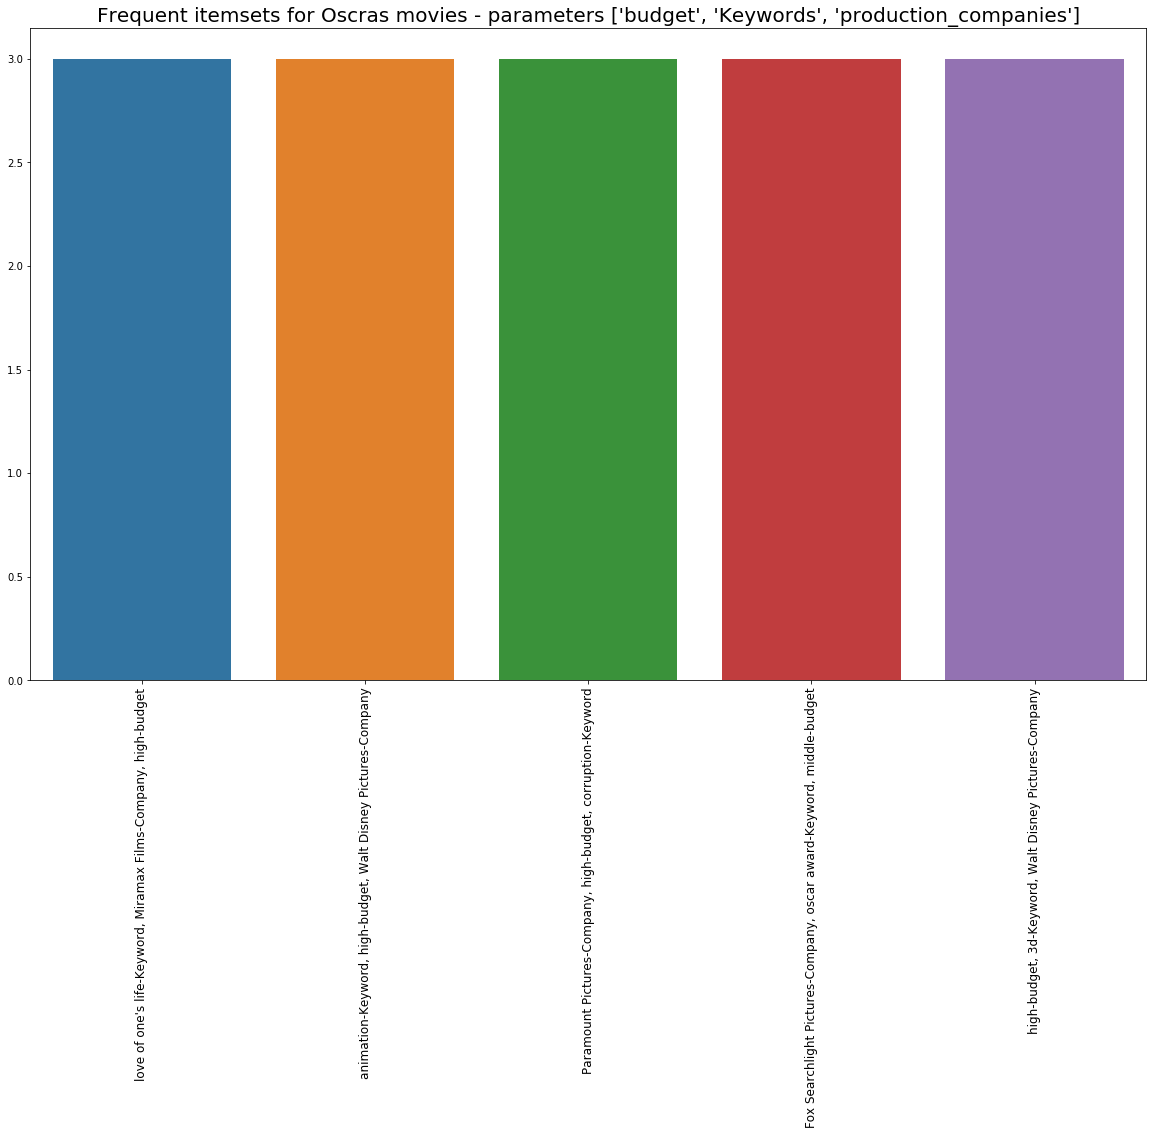

In [151]:
#Frequet itemsets for resolved vectors
processedDataset = oscar_movies.copy()
features_vector = ['Keywords', 'production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['Keywords'] = processedDataset['Keywords'].apply(lambda x: [i['name']+'-Keyword' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: classify_movie_budget(x))
processedDataset = processedDataset.explode('Keywords').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
processedDataset = processedDataset[processedDataset['budget'] != 'no data']
processedDataset = processedDataset[processedDataset['Keywords'] != 'nan']

processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset
ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(3,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for Oscras movies - parameters ['budget', 'Keywords', 'production_companies']", frequent_itemsets, len(df), rotation=90)

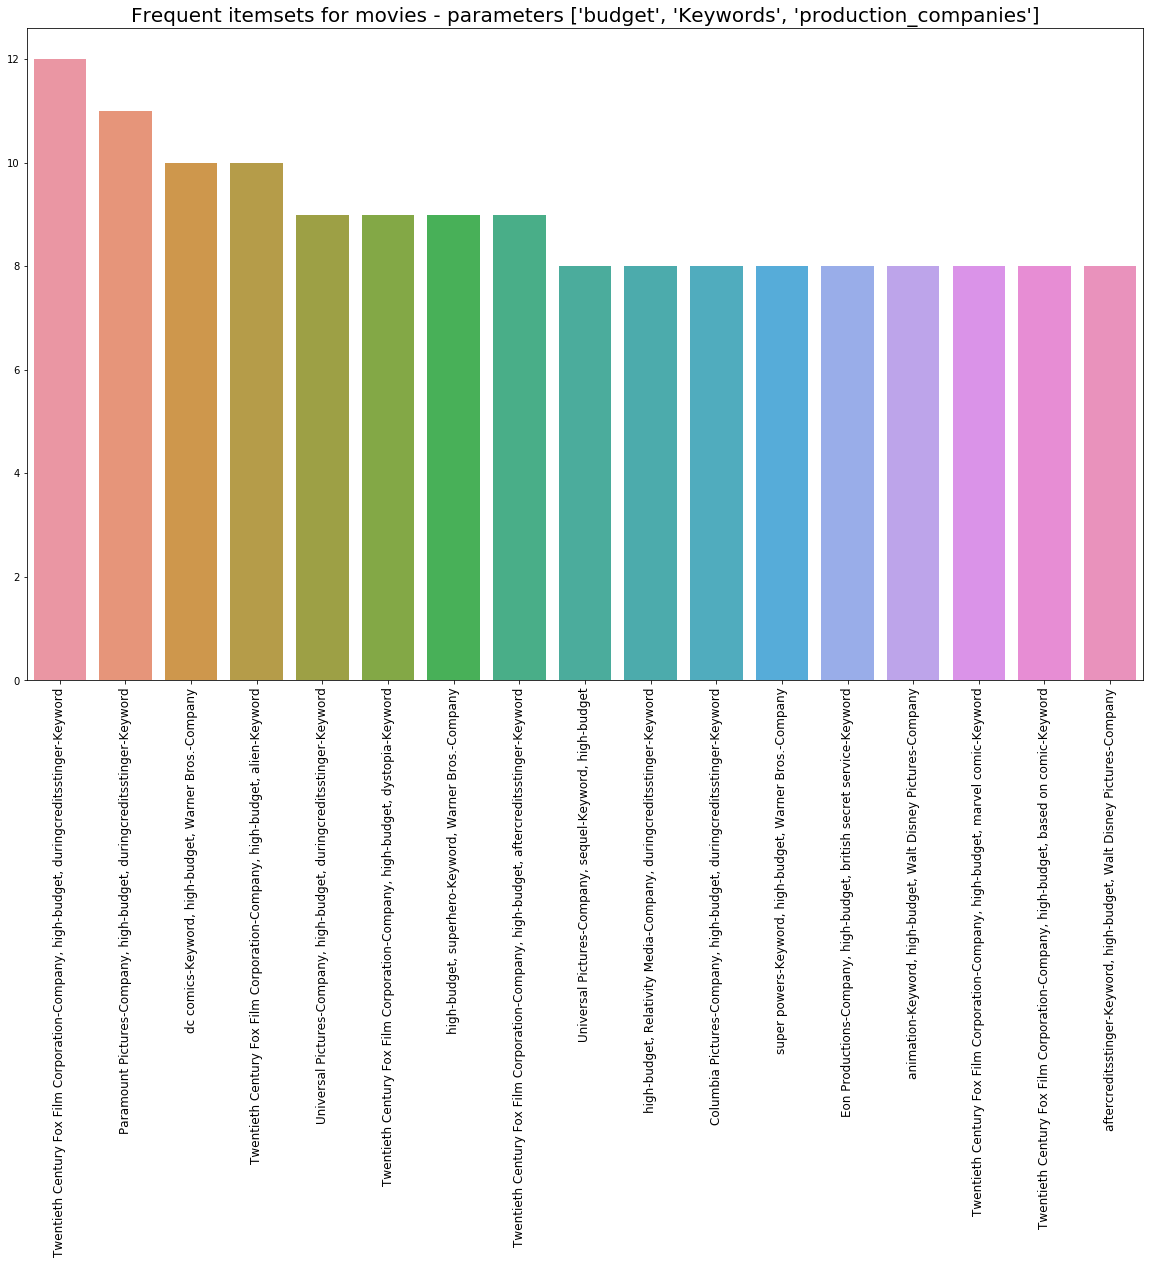

In [149]:
#Frequet itemsets for resolved vectors
processedDataset = dataset.copy()
features_vector = ['Keywords', 'production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['Keywords'] = processedDataset['Keywords'].apply(lambda x: [i['name']+'-Keyword' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: classify_movie_budget(x))
processedDataset = processedDataset.explode('Keywords').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
processedDataset = processedDataset[processedDataset['budget'] != 'no data']
processedDataset = processedDataset[processedDataset['Keywords'] != 'nan']

processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset
ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(8,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies - parameters ['budget', 'Keywords', 'production_companies']", frequent_itemsets, len(df), rotation=90)

In [153]:
#Frequet itemsets for resolved vectors
processedDataset = oscar_movies.copy()
features_vector = ['cast', 'crew']
processedDataset = processedDataset[features_vector]

processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['crew'] = processedDataset['crew'].apply(lambda x: [i['name']+'-'+i['job'] for i in x] if x != {} else [])
processedDataset = processedDataset.explode('cast').reset_index(drop=True)
processedDataset = processedDataset.explode('crew').reset_index(drop=True)


processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

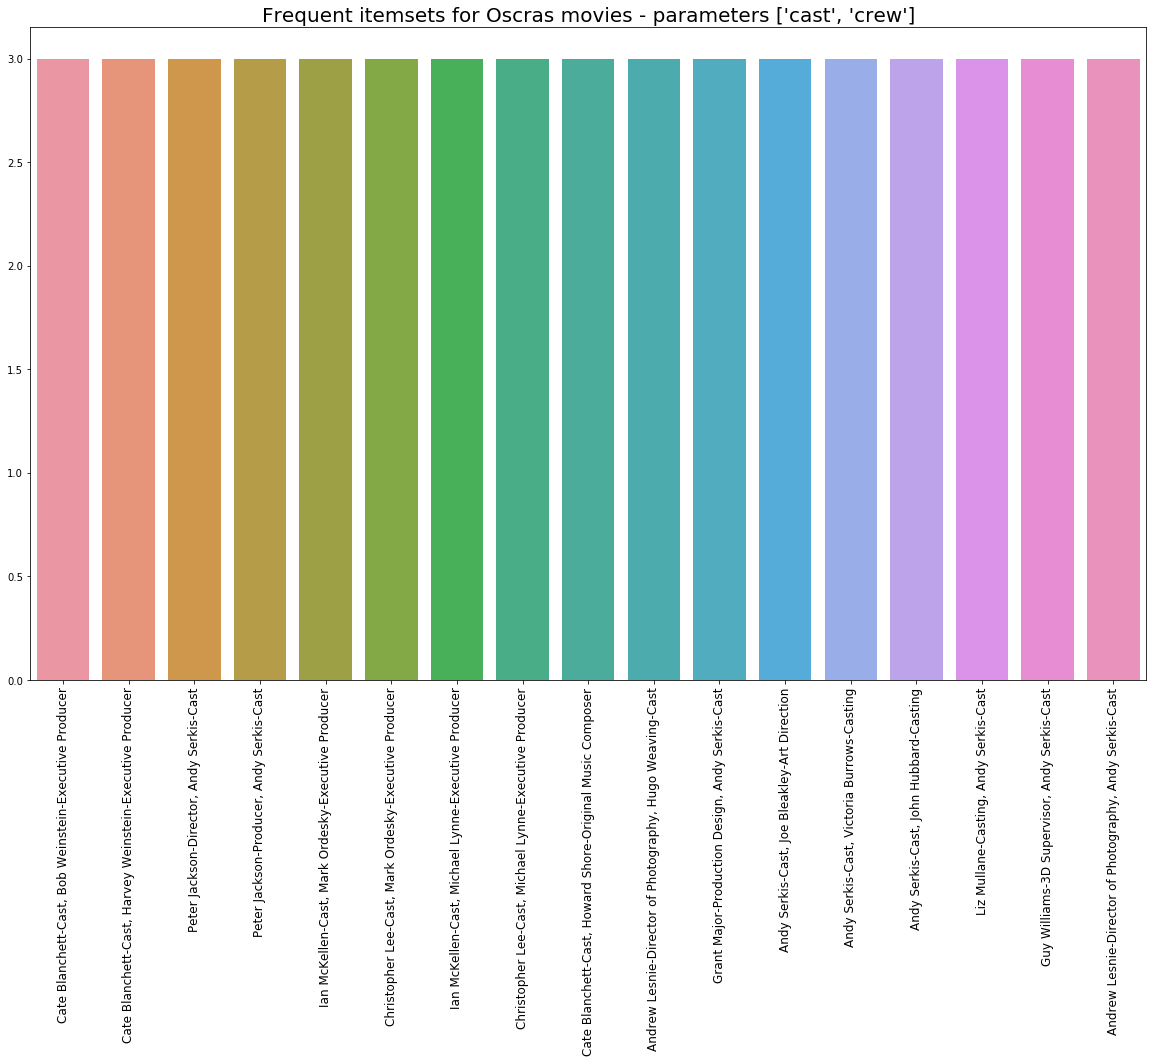

In [155]:
ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(3,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for Oscras movies - parameters ['cast', 'crew']", frequent_itemsets, len(df), rotation=90)

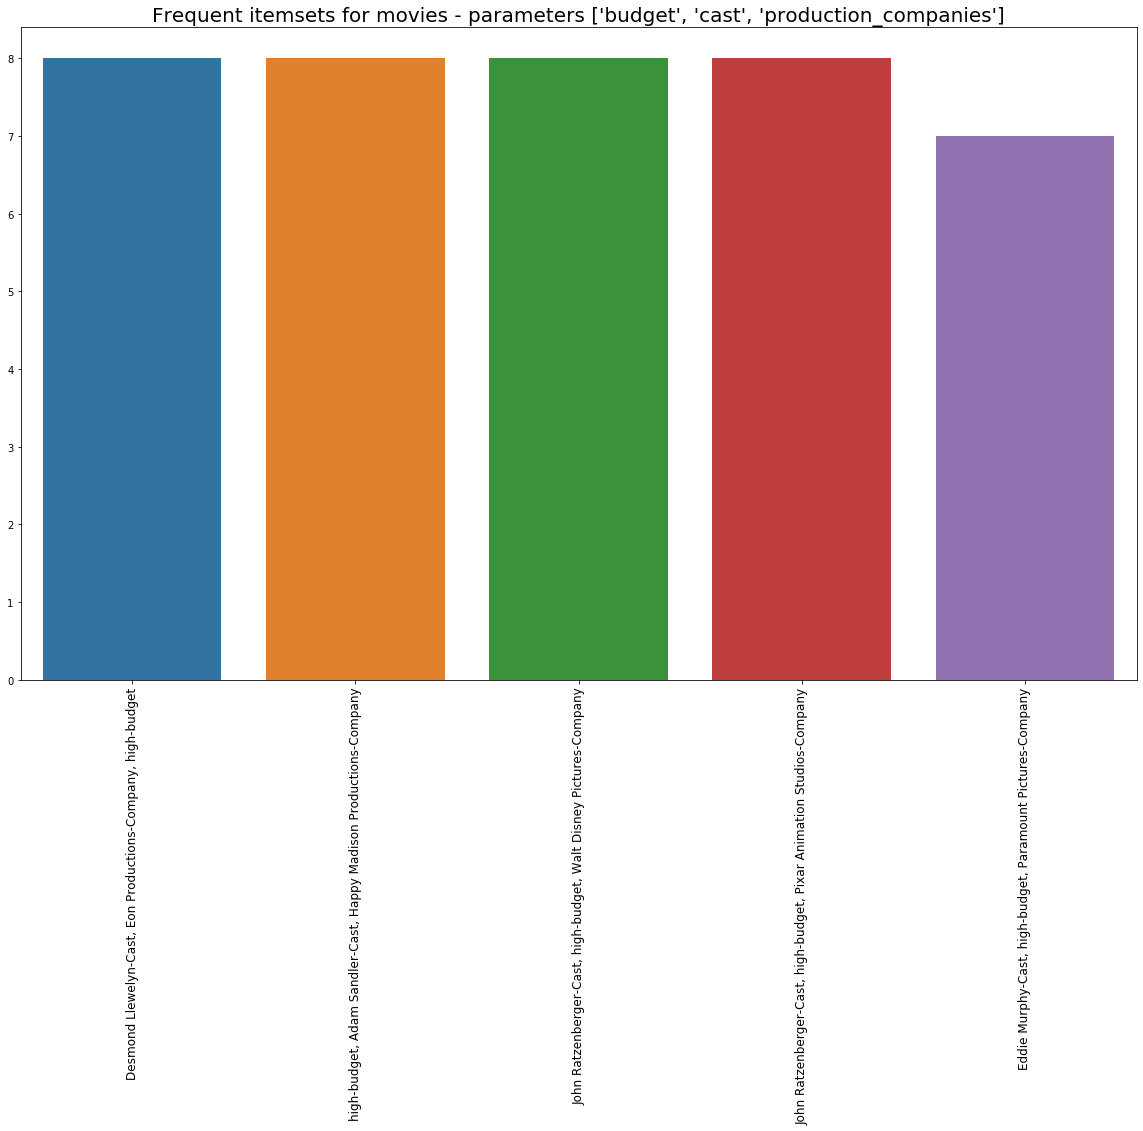

In [161]:
#Frequet itemsets for resolved vectors
processedDataset = dataset.copy()
features_vector = ['cast', 'production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: classify_movie_budget(x))
processedDataset = processedDataset.explode('cast').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
processedDataset = processedDataset[processedDataset['budget'] != 'no data']

processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset
ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(7,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies - parameters ['budget', 'cast', 'production_company']", frequent_itemsets, len(df), rotation=90)

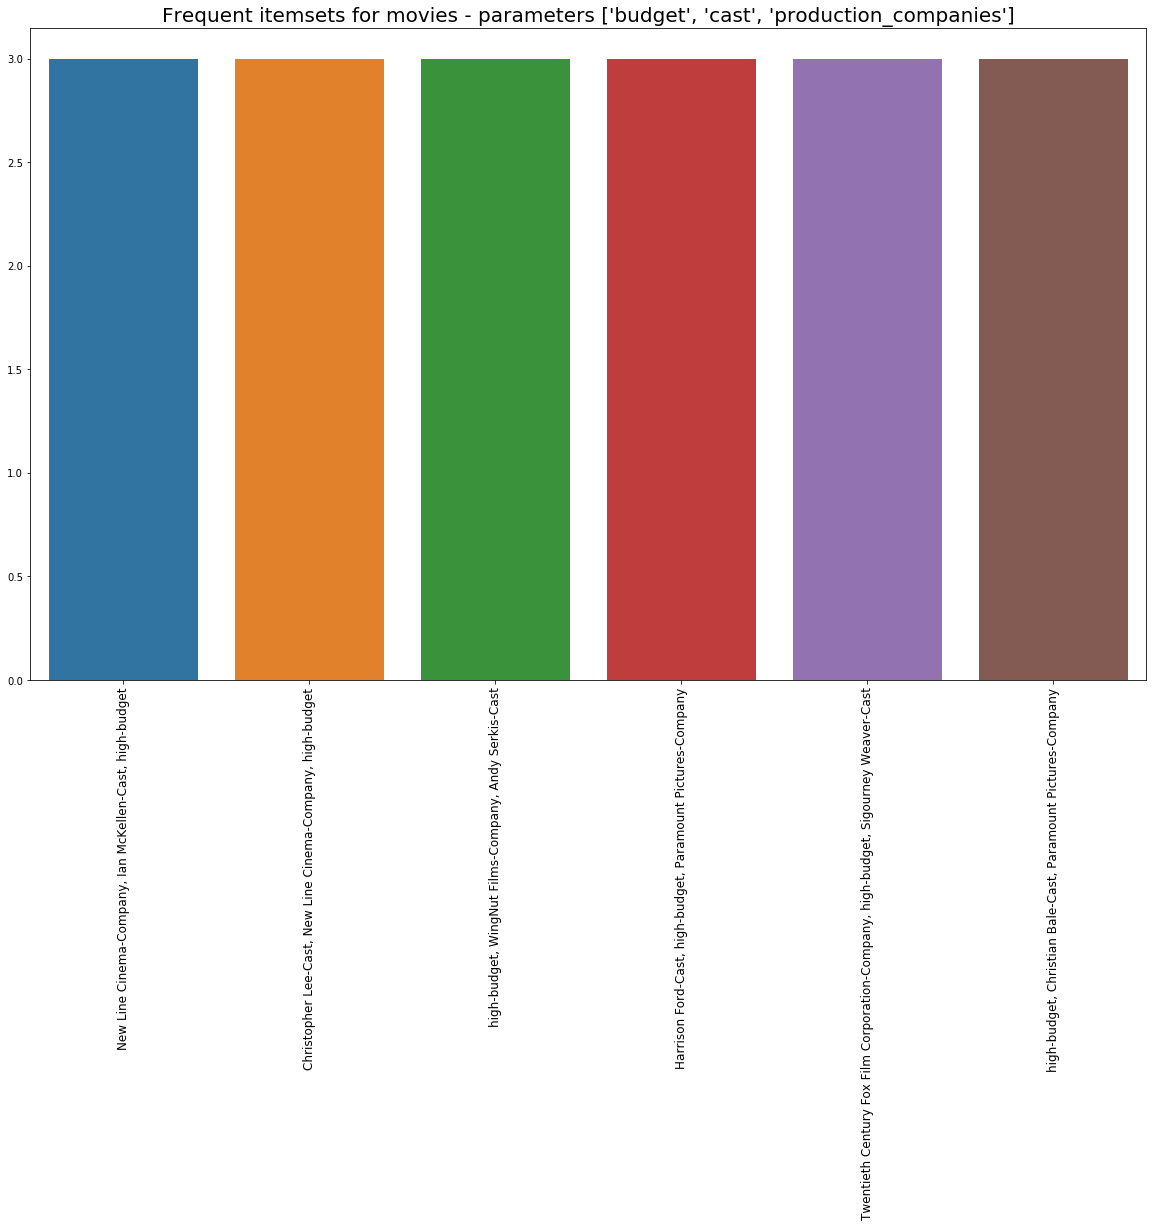

In [163]:
#Frequet itemsets for resolved vectors
processedDataset = oscar_movies.copy()
features_vector = ['cast', 'production_companies', 'budget']
processedDataset = processedDataset[features_vector]

processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['budget'] = processedDataset['budget'].apply(lambda x: classify_movie_budget(x))
processedDataset = processedDataset.explode('cast').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
processedDataset = processedDataset[processedDataset['budget'] != 'no data']

processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset
ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(3,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies - parameters ['budget', 'cast', 'production_company']", frequent_itemsets, len(df), rotation=90)

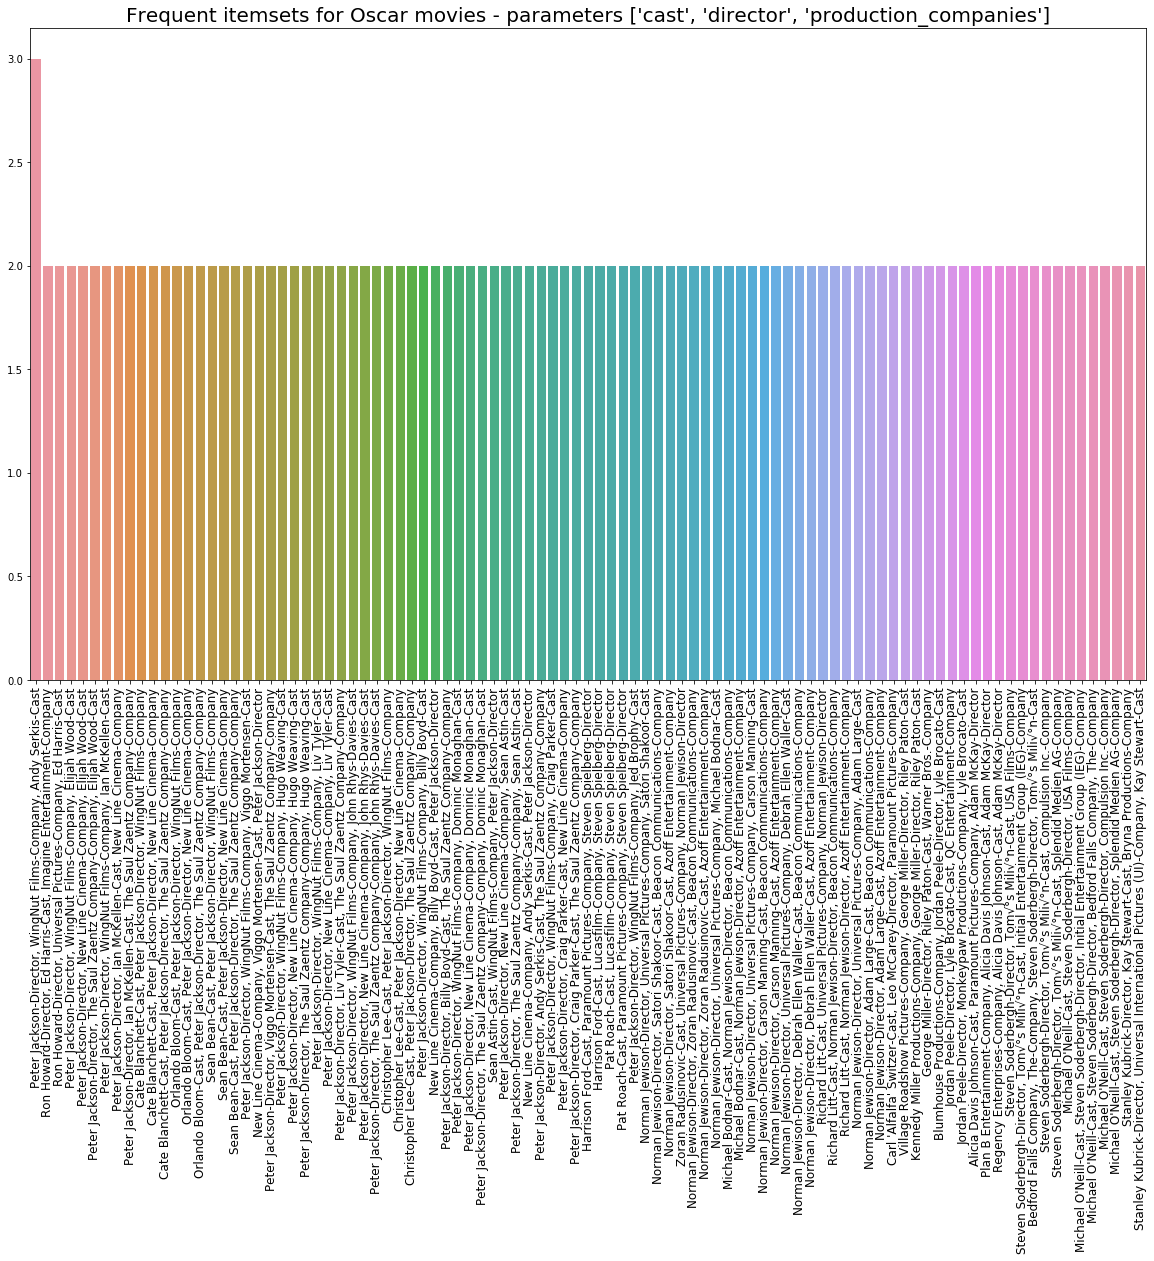

In [170]:
#Frequet itemsets for resolved vectors
processedDataset = oscar_movies.copy()
features_vector = ['cast', 'crew', 'production_companies']
processedDataset = processedDataset[features_vector]

processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['crew'] = processedDataset['crew'].apply(lambda x: [i['name']+'-'+i['job'] for i in x if i['job'] == 'Director'] if x != {} else [])
processedDataset = processedDataset.explode('cast').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
processedDataset = processedDataset.explode('crew').reset_index(drop=True)
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset

ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(2,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for Oscar movies - parameters ['cast', 'director', 'production_company']", frequent_itemsets, len(df), rotation=90)

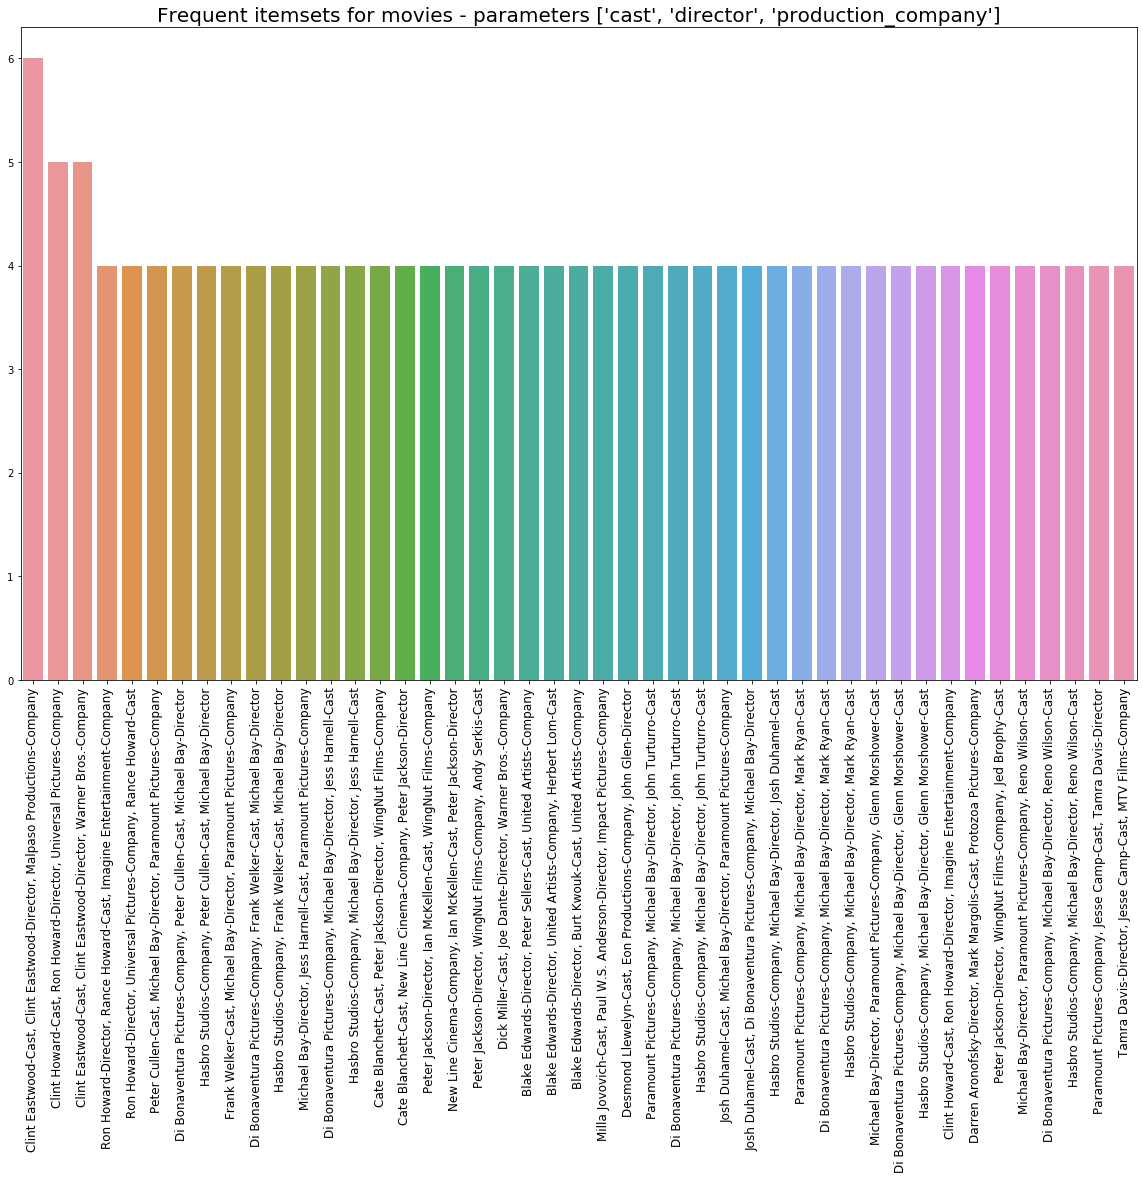

In [174]:
#Frequet itemsets for resolved vectors
processedDataset = dataset.copy()
features_vector = ['cast', 'crew', 'production_companies']
processedDataset = processedDataset[features_vector]

processedDataset['cast'] = processedDataset['cast'].apply(lambda x: [i['name']+'-Cast' for i in x] if x != {} else [])
processedDataset['production_companies'] = processedDataset['production_companies'].apply(lambda x: [i['name']+'-Company' for i in x] if x != {} else [])
processedDataset['crew'] = processedDataset['crew'].apply(lambda x: [i['name']+'-'+i['job'] for i in x if i['job'] == 'Director'] if x != {} else [])
processedDataset = processedDataset.explode('cast').reset_index(drop=True)
processedDataset = processedDataset.explode('production_companies').reset_index(drop=True)
processedDataset = processedDataset.explode('crew').reset_index(drop=True)
processedDataset['elements'] = processedDataset.values.tolist() 
processedDataset['elements'] = processedDataset['elements'].apply(lambda x: [str(item) for item in x])

processedDataset

ds = processedDataset['elements']
te = TransactionEncoder()
te_ary = te.fit(ds).transform(ds)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df,min_support=calculate_support(4,len(df)), use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 3)]
frequent_itemsets = frequent_itemsets.sort_values(['support', 'length'], ascending=[False, False])
plot_itemset("Frequent itemsets for movies - parameters ['cast', 'director', 'production_company']", frequent_itemsets, len(df), rotation=90)

In [226]:
#clustering
processedDataset = dataset.copy()
features_vector = ['title', 'budget', 'revenue', 'popularity', 'runtime']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset[processedDataset['budget'] != 0]
processedDataset.sort_values(['popularity', 'budget'], ascending=[False, False])


,title,budget,revenue,popularity,runtime
518,Wonder Woman,149000000,820580447,294.337037,141.0
684,Beauty and the Beast,160000000,1262886337,287.253654,129.0
1695,Baby Driver,34000000,224511319,228.032744,113.0
2326,Deadpool,58000000,783112979,187.860492,108.0
2126,Guardians of the Galaxy Vol. 2,200000000,863416141,185.330992,137.0
...,...,...,...,...,...
1757,Journey from the Fall,1300000,639000,0.044561,135.0
2295,The Amazing Truth About Queen Raquela,400000,5255,0.038876,80.0
2010,Cheetah,5000000,8153677,0.011574,83.0
457,Swoon,250000,340147,0.003013,82.0


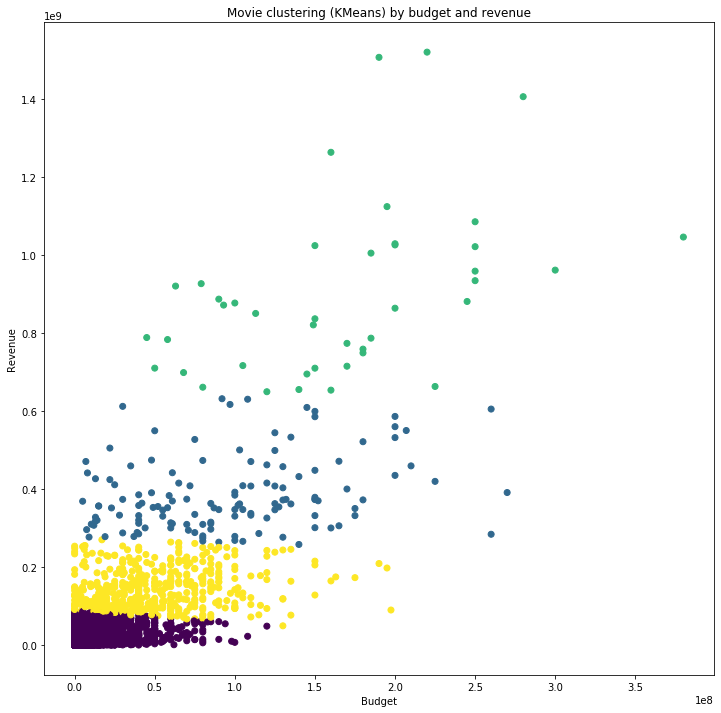

In [227]:
processedDataset = dataset.copy()
features_vector = ['budget', 'revenue']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()

plt.figure(figsize=(12, 12))

random_state = 13
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(processedDataset)

plt.subplot(111)
plt.scatter(processedDataset['budget'], processedDataset['revenue'], c=y_pred)
plt.title("Movie clustering (KMeans) by budget and revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

In [188]:
processedDataset

,budget,popularity
0,14000000,6.575393
1,40000000,8.248895
2,3300000,64.299990
3,1200000,3.174936
4,0,1.148070
...,...,...
2995,0,9.853270
2996,0,3.727996
2997,65000000,14.482345
2998,42000000,15.725542


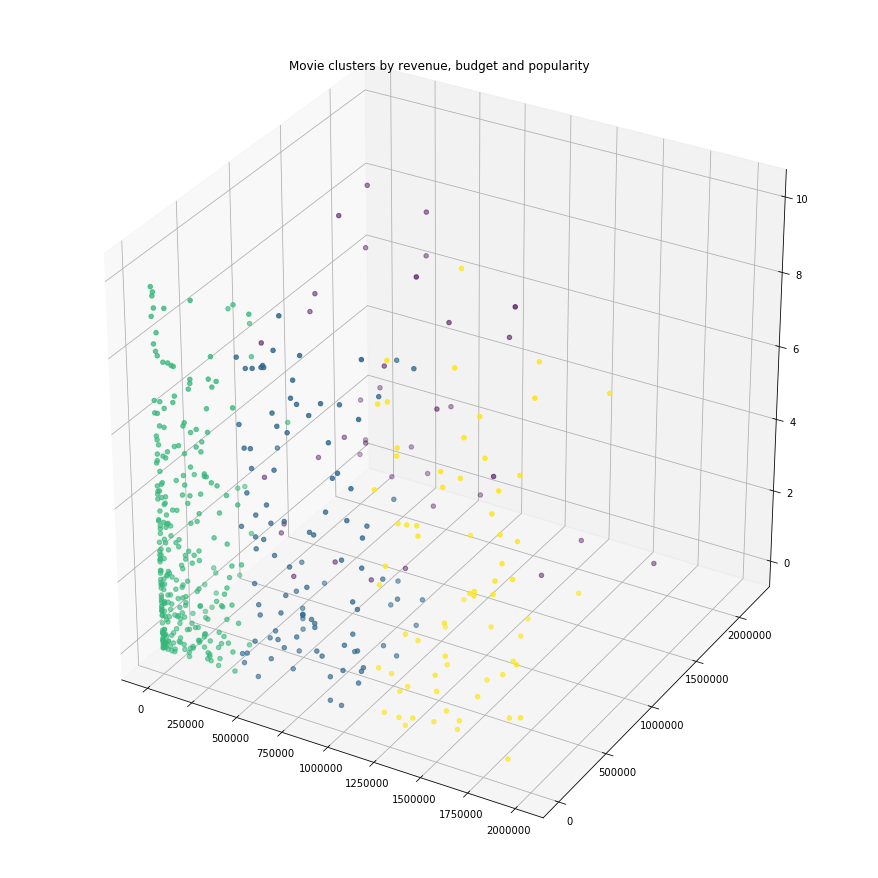

In [259]:
processedDataset = dataset.copy()
features_vector = ['revenue','budget','popularity']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset = processedDataset[processedDataset['popularity'] < 10]
processedDataset = processedDataset[processedDataset['revenue'] < 2000000]
processedDataset = processedDataset[processedDataset['budget'] < 2500000]

fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig)

random_state = 170
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(processedDataset)

ax.scatter(processedDataset['revenue'], processedDataset['budget'], processedDataset['popularity'], c=y_pred)
plt.title("Movie clusters by revenue, budget and popularity")

plt.show()

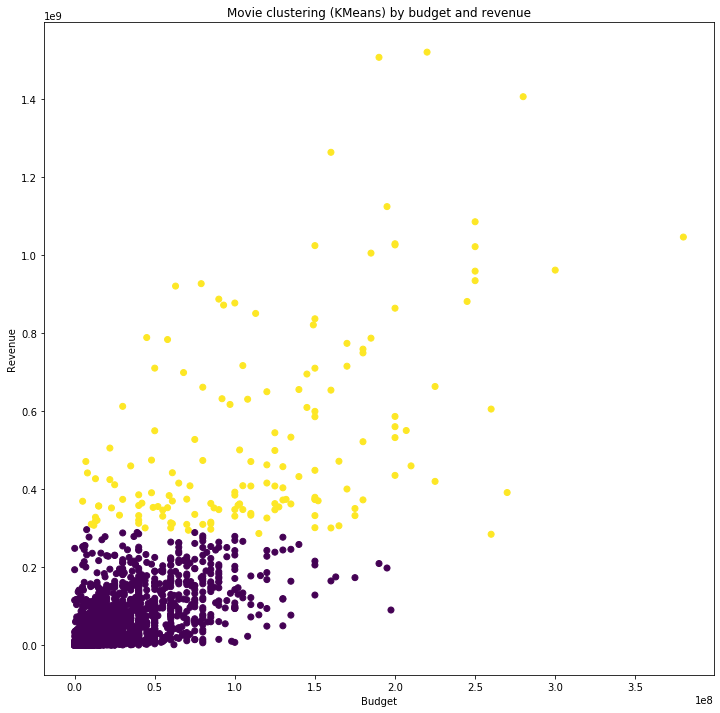

In [249]:
processedDataset = dataset.copy()
features_vector = ['budget', 'revenue']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset = processedDataset[processedDataset['budget'] > 0]

plt.figure(figsize=(12, 12))

random_state = 13
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(processedDataset)

plt.subplot(111)
plt.scatter(processedDataset['budget'], processedDataset['revenue'], c=y_pred)
plt.title("Movie clustering (KMeans) by budget and revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

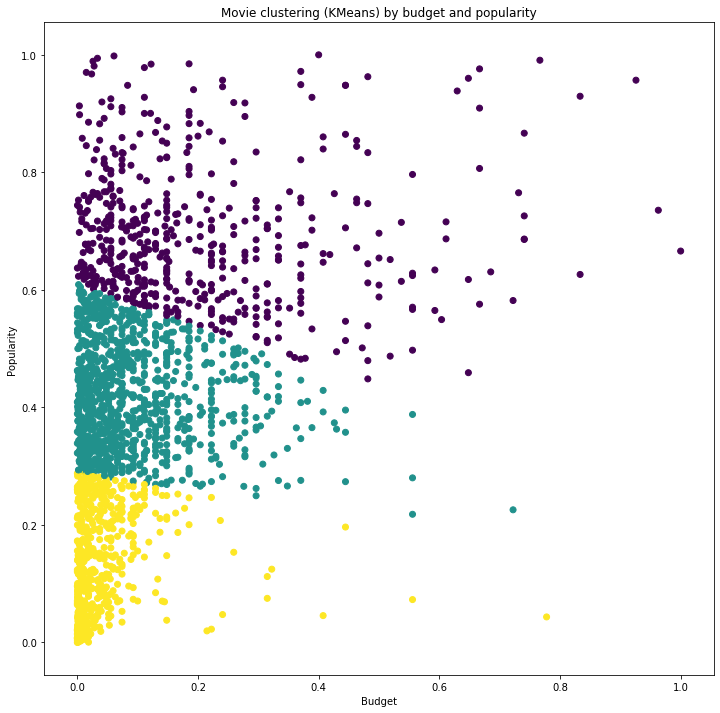

In [258]:
processedDataset = dataset.copy()
features_vector = ['budget', 'popularity']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset = processedDataset[processedDataset['popularity'] < 20]
processedDataset = processedDataset[processedDataset['budget'] > 0]
processedDataset=(processedDataset-processedDataset.min())/(processedDataset.max()-processedDataset.min())

plt.figure(figsize=(12, 12))

random_state = 13
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(processedDataset)

plt.subplot(111)
plt.scatter(processedDataset['budget'], processedDataset['popularity'], c=y_pred)
plt.title("Movie clustering (KMeans) by budget and popularity")
plt.xlabel("Budget")
plt.ylabel("Popularity")
plt.show()

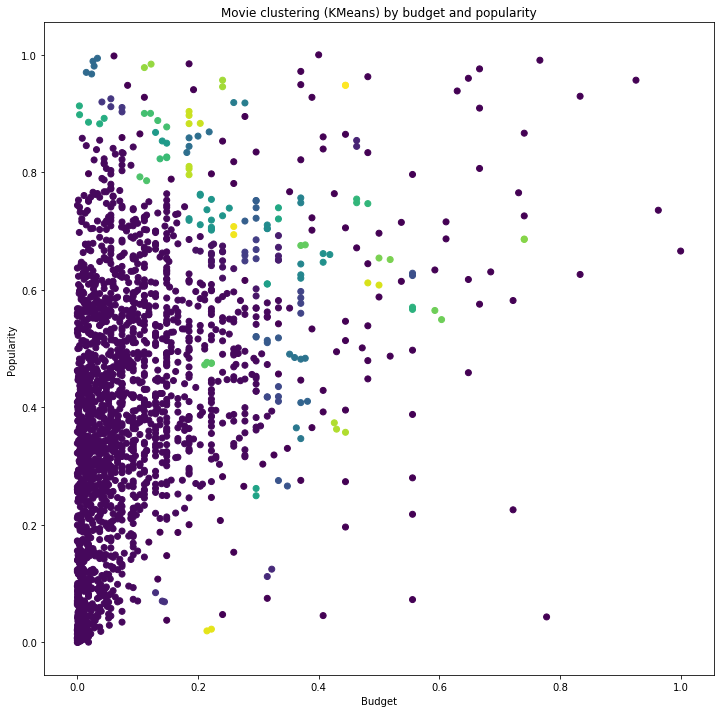

In [266]:
processedDataset = dataset.copy()
features_vector = ['budget', 'popularity']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset = processedDataset[processedDataset['popularity'] < 20]
processedDataset = processedDataset[processedDataset['budget'] > 0]
processedDataset=(processedDataset-processedDataset.min())/(processedDataset.max()-processedDataset.min())

plt.figure(figsize=(12, 12))

y_pred = DBSCAN(eps=0.02, min_samples=2).fit(processedDataset)
y_pred =y_pred.labels_

plt.subplot(111)
plt.scatter(processedDataset['budget'], processedDataset['popularity'], c=y_pred)
plt.title("Movie clustering (DBSCAN) by budget and popularity")
plt.xlabel("Budget")
plt.ylabel("Popularity")
plt.show()

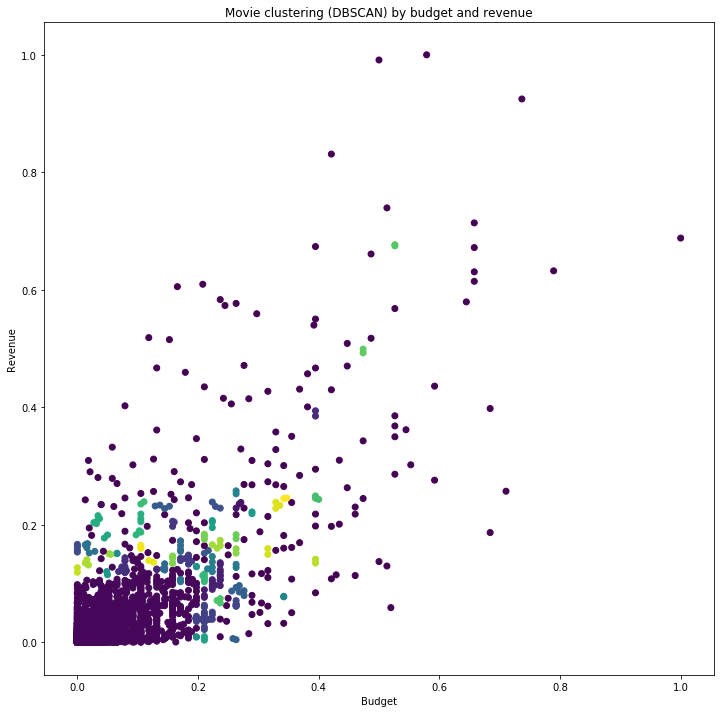

In [272]:
processedDataset = dataset.copy()
features_vector = ['budget', 'revenue']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset=(processedDataset-processedDataset.min())/(processedDataset.max()-processedDataset.min())

plt.figure(figsize=(12, 12))

y_pred = DBSCAN(eps=0.01, min_samples=2).fit(processedDataset)
y_pred =y_pred.labels_

plt.subplot(111)
plt.scatter(processedDataset['budget'], processedDataset['revenue'], c=y_pred)
plt.title("Movie clustering (DBSCAN) by budget and revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

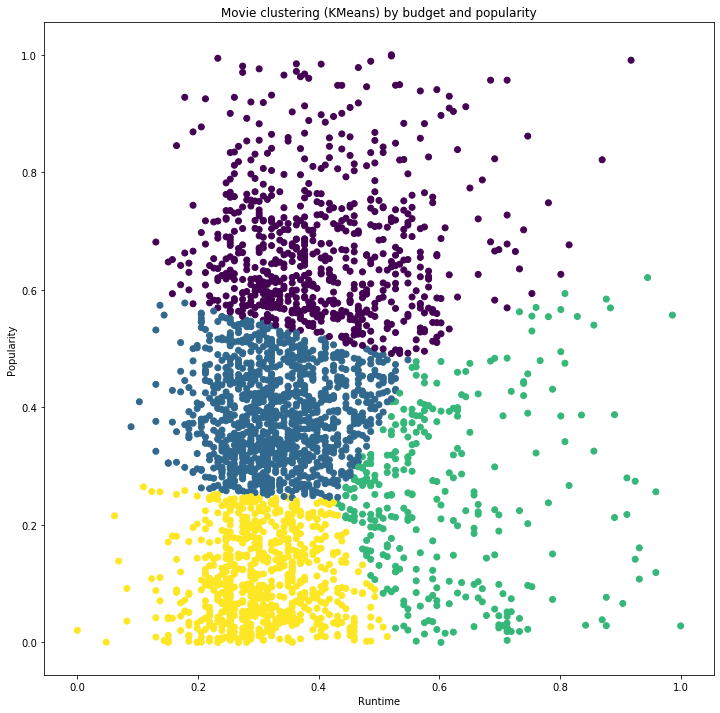

In [278]:
processedDataset = dataset.copy()
features_vector = ['runtime', 'popularity']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset = processedDataset[processedDataset['popularity'] < 20]
processedDataset = processedDataset[processedDataset['runtime'] < 200]
processedDataset = processedDataset[processedDataset['runtime'] > 50]
processedDataset=(processedDataset-processedDataset.min())/(processedDataset.max()-processedDataset.min())

plt.figure(figsize=(12, 12))

random_state = 13
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(processedDataset)

plt.subplot(111)
plt.scatter(processedDataset['runtime'], processedDataset['popularity'], c=y_pred)
plt.title("Movie clustering (KMeans) by runtime and popularity")
plt.xlabel("Runtime")
plt.ylabel("Popularity")
plt.show()

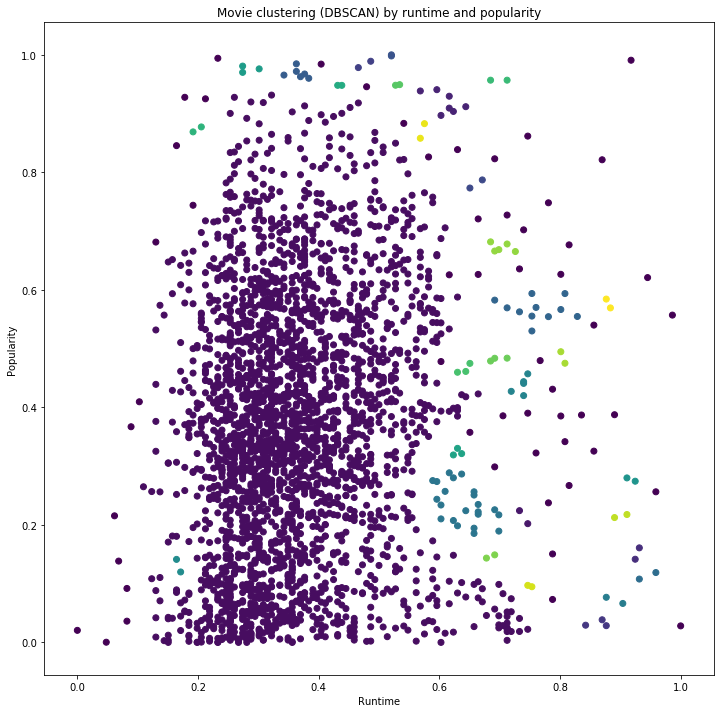

In [282]:
processedDataset = dataset.copy()
features_vector = ['runtime', 'popularity']
processedDataset = processedDataset[features_vector]
processedDataset = processedDataset.dropna()
processedDataset = processedDataset[processedDataset['popularity'] < 20]
processedDataset = processedDataset[processedDataset['runtime'] < 200]
processedDataset = processedDataset[processedDataset['runtime'] > 50]
processedDataset=(processedDataset-processedDataset.min())/(processedDataset.max()-processedDataset.min())

plt.figure(figsize=(12, 12))

y_pred = DBSCAN(eps=0.03, min_samples=2).fit(processedDataset)
y_pred =y_pred.labels_

plt.subplot(111)
plt.scatter(processedDataset['runtime'], processedDataset['popularity'], c=y_pred)
plt.title("Movie clustering (DBSCAN) by runtime and popularity")
plt.xlabel("Runtime")
plt.ylabel("Popularity")
plt.show()